<a href="https://colab.research.google.com/github/ykitaguchi77/FundusPhoto/blob/main/Metabo2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Fundus_metabolic**

In [1]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

# Mount Google Drive if the CSV is in your drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**元データの分析**

Basic statistics of the dataset:
               age           AC          SBP          DBP         HDLC  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean     46.856800    89.660860   132.864200    82.332600    54.038600   
std      10.634873    10.709773    15.308855    12.034939    13.889395   
min      18.000000    58.000000    89.000000    46.000000    20.000000   
25%      39.000000    82.800000   123.000000    74.000000    44.000000   
50%      48.000000    89.200000   132.000000    82.000000    52.000000   
75%      55.000000    96.000000   141.000000    90.000000    62.000000   
max      65.000000   157.800000   219.000000   139.000000   118.000000   

                TG           BS        METS  
count  5000.000000  5000.000000  5000.00000  
mean    174.856000    96.231000     0.50000  
std     152.419455    26.904461     0.50005  
min      22.000000    44.000000     0.00000  
25%      86.000000    83.000000     0.00000  
50%     149.000000    88

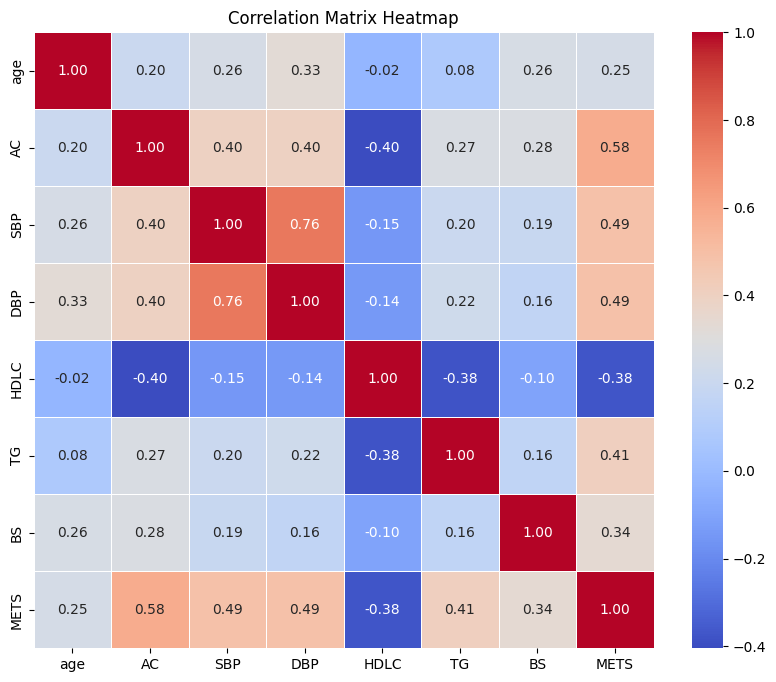

In [ ]:
# Load the CSV file (adjust the path if necessary)
file_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv'  # Adjust this to your actual file path
data = pd.read_csv(file_path)

# Display basic statistics
print("Basic statistics of the dataset:")
print(data.describe())

# Drop non-numeric columns for correlation analysis
numeric_data = data.drop(columns=["filename"])

# Calculate and display the correlation matrix
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()


### Gradient Boostingを使用

In [ ]:
####
# 他のデータからGradient Boostingを用いてMETSを予測すると、精度は99%以上とかなり高い
####

# Prepare the data for training (remove the filename and target column)
X = numeric_data.drop(columns=["METS"])
y = numeric_data["METS"]

# Initialize the Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=42)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(gb_model, X, y, cv=5, scoring='accuracy')

# Display the cross-validation results
print("5-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

5-Fold Cross-Validation Accuracy Scores: [0.993 0.991 1.    1.    1.   ]
Mean Accuracy: 0.9968


In [ ]:
#########
# 重要なTOP3指標を抜き出してみる --> AC（腹囲), TG（中性脂肪）, BS（空腹時血糖）
#########

# Train the Gradient Boosting model
gb_model.fit(X, y)

# Get feature importances from the Gradient Boosting model
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Feature Importances for Gradient Boosting:")
print(feature_importances)


Feature Importances for Gradient Boosting:
  Feature  Importance
1      AC    0.432137
5      TG    0.242165
6      BS    0.147832
2     SBP    0.093333
4    HDLC    0.046051
3     DBP    0.038421
0     age    0.000062


In [ ]:
# このスクリプトは、メタボリックシンドローム（METS）の予測のために
# 各健康指標のカットオフ値を決定し、それに基づいてデータを2値化します。
#
# 主な手順：
# 1. Google Driveからデータを読み込む
# 2. 各健康指標（年齢、腹囲、血圧など）に対して以下の処理を行う：
#    a. ROC曲線を計算（HDLCの場合は値を反転）
#    b. Youden index（感度+特異度-1）を計算
#    c. Youden indexが最大となるポイントをカットオフ値として決定
#    d. カットオフ値を基準にデータを2値化（HDLCは逆基準）
# 3. 各指標のROC曲線をプロット
# 4. 結果（カットオフ値、感度、特異度、Youden index、高低の症例数）を表示
# 5. Youden indexの比較グラフを作成
# 6. カットオフ値周りの症例分布を棒グラフで表示
# 7. 2値化したデータを新しいデータフレームとして作成（filename, METSを含む）
# 8. 2値化したデータをCSVファイルとして保存
#
# 注意点：
# - HDLCは他の指標と逆の関係（高いほど良い）であるため、特別な処理を行っています。
# - 2値化の基準は、カットオフ値より大きい場合を1、それ以外を0としています（HDLCは逆）。
# - 結果のCSVファイルは元のファイルと同じディレクトリに保存されます。
# - filenameとMETSは元のデータからそのまま引き継がれます。

import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Google Driveからデータの読み込み
data = pd.read_csv('/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv')

# 分析対象の列
features = ['age', 'AC', 'SBP', 'DBP', 'HDLC', 'TG', 'BS']

# 結果を格納するリスト
results_list = []

# 2値化したデータを格納するデータフレーム
binary_data = pd.DataFrame()

# filenameとMETSを追加
binary_data['filename'] = data['filename']
binary_data['METS'] = data['METS']

# 各特徴量に対して解析を行う
for feature in features:
    # HDLCの場合は値を反転させる（高値が望ましいため）
    if feature == 'HDLC':
        feature_values = -data[feature]
    else:
        feature_values = data[feature]

    # ROC曲線の計算
    fpr, tpr, thresholds = roc_curve(data['METS'], feature_values)

    # Youden indexの計算
    youden_index = tpr - fpr

    # 最適なカットオフ値の決定
    optimal_idx = np.argmax(youden_index)
    optimal_threshold = thresholds[optimal_idx]

    # HDLCの場合はカットオフ値を元の尺度に戻す
    if feature == 'HDLC':
        optimal_threshold = -optimal_threshold
        # HDLCの場合、"高い"と"低い"の意味が逆になる
        high_count = (data[feature] <= optimal_threshold).sum()
        low_count = (data[feature] > optimal_threshold).sum()
        # 2値化（HDLCは逆の基準で2値化）
        binary_data[f'{feature}_binary'] = (data[feature] <= optimal_threshold).astype(int)
    else:
        high_count = (data[feature] > optimal_threshold).sum()
        low_count = (data[feature] <= optimal_threshold).sum()
        # 2値化
        binary_data[f'{feature}_binary'] = (data[feature] > optimal_threshold).astype(int)

    # 結果の保存
    results_list.append({
        'Feature': feature,
        'Cutoff': optimal_threshold,
        'Sensitivity': tpr[optimal_idx],
        'Specificity': 1 - fpr[optimal_idx],
        'Youden Index': youden_index[optimal_idx],
        'High Count': high_count,
        'Low Count': low_count
    })

    # # ROC曲線のプロット
    # plt.figure(figsize=(8, 6))
    # plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(data["METS"], feature_values):.2f})')
    # plt.plot([0, 1], [0, 1], 'k--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title(f'ROC Curve for {feature}')
    # plt.legend(loc="lower right")
    # plt.show()

# 結果をデータフレームに変換
results = pd.DataFrame(results_list)

# 結果の表示
print(results.to_string(index=False))

# # 結果のプロット
# plt.figure(figsize=(10, 6))
# plt.bar(results['Feature'], results['Youden Index'])
# plt.title('Youden Index for Each Feature')
# plt.xlabel('Feature')
# plt.ylabel('Youden Index')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # 症例数の比較プロット
# plt.figure(figsize=(12, 6))
# x = np.arange(len(features))
# width = 0.35
# plt.bar(x - width/2, results['High Count'], width, label='High')
# plt.bar(x + width/2, results['Low Count'], width, label='Low')
# plt.xlabel('Features')
# plt.ylabel('Count')
# plt.title('Distribution of Cases Around Cutoff')
# plt.xticks(x, features, rotation=45)
# plt.legend()
# plt.tight_layout()
# plt.show()

# 2値化したデータフレームの先頭数行を表示
print("\n2値化したデータフレーム（先頭10行）:")
print(binary_data.head(10))

# 2値化したデータフレームをCSVファイルとして保存
binary_data.to_csv('/content/drive/MyDrive/Deep_learning/Fundus_metabolic/binary_features.csv', index=False)
print("\n2値化したデータをCSVファイルとして保存しました: '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/binary_features.csv'")

Feature  Cutoff  Sensitivity  Specificity  Youden Index  High Count  Low Count
    age    46.0       0.6972       0.5200        0.2172        2781       2219
     AC    85.5       0.9844       0.6468        0.6312        3320       1680
    SBP   130.0       0.8644       0.7040        0.5684        2715       2285
    DBP    80.0       0.8212       0.6432        0.4644        2788       2212
   HDLC    55.0       0.7648       0.5624        0.3272        3006       1994
     TG   150.0       0.8316       0.8332        0.6648        2464       2536
     BS    94.0       0.5088       0.8220        0.3308        1604       3396

2値化したデータフレーム（先頭10行）:
                filename  METS  age_binary  AC_binary  SBP_binary  DBP_binary  \
0  img75151275_00_1R.jpg     1           1          1           1           1   
1  img96940480_00_1R.jpg     0           1          0           1           1   
2  img15900654_00_1R.jpg     1           1          1           0           1   
3  img74960801_00_1R.j

### NGBoostを使用

In [ ]:
#####
# あとでCNNと合体することを想定し、NGBoostを使う
#####
!pip install ngboost
from ngboost import NGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import numpy as np

# Prepare the data for training (remove the filename and target column)
X = numeric_data.drop(columns=["METS"])
y = numeric_data["METS"]

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'minibatch_frac': [1.0, 0.8, 0.6],
    'col_sample': [1.0, 0.8, 0.6],
}

# Initialize the NGBoost model
ngb_model = NGBClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=ngb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X, y)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Perform 5-fold cross-validation with the best model
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')

# Display the results
print("Best Parameters:", best_params)
print("5-Fold Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())

[iter 0] loss=0.6931 val_loss=0.0000 scale=8.0000 norm=16.0000
[iter 100] loss=0.0206 val_loss=0.0000 scale=1.0000 norm=1.0232
[iter 0] loss=0.6909 val_loss=0.0000 scale=8.0000 norm=16.0000
[iter 100] loss=0.0149 val_loss=0.0000 scale=1.0000 norm=1.0166
[iter 0] loss=0.6924 val_loss=0.0000 scale=16.0000 norm=32.0000
[iter 100] loss=0.0160 val_loss=0.0000 scale=0.2500 norm=0.2544
[iter 0] loss=0.6928 val_loss=0.0000 scale=8.0000 norm=16.0000
[iter 100] loss=0.0178 val_loss=0.0000 scale=0.2500 norm=0.2549
[iter 0] loss=0.6929 val_loss=0.0000 scale=8.0000 norm=16.0000
[iter 100] loss=0.0205 val_loss=0.0000 scale=0.5000 norm=0.5115
[iter 0] loss=0.6869 val_loss=0.0000 scale=16.0000 norm=32.0000
[iter 100] loss=0.0216 val_loss=0.0000 scale=0.0625 norm=0.0640
Best Parameters: {'col_sample': 0.8, 'learning_rate': 0.05, 'minibatch_frac': 1.0, 'n_estimators': 200}
5-Fold Cross-Validation Accuracy Scores: [1.    0.996 1.    1.    1.   ]
Mean Accuracy: 0.9992000000000001
Standard Deviation: 0.001

In [ ]:
## NGBooostを用いた場合の関連因子

from ngboost import NGBClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data
X = numeric_data.drop(columns=["METS"])
y = numeric_data["METS"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model with the best parameters
best_model = NGBClassifier(col_sample=0.8, learning_rate=0.05, minibatch_frac=1.0, n_estimators=200, random_state=42)
best_model.fit(X_train, y_train)

# Perform permutation importance
result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42)

# Sort features by importance
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': result.importances_mean})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Display the top 10 most important features
print("Top 10 most important features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Feature Importance")
plt.tight_layout()
plt.show()

In [ ]:
### TOP3だけで予測すると物足りない
# Select only the top 3 features: AC, TG, BS
X_top3 = data[['AC', 'TG', 'BS']]

# Perform 5-fold cross-validation using only these 3 features with Gradient Boosting
cv_scores_top3 = cross_val_score(gb_model, X_top3, y, cv=5, scoring='accuracy')

# Display the cross-validation results
cv_scores_top3, cv_scores_top3.mean()


(array([0.939, 0.918, 0.951, 0.945, 0.932]), 0.9369999999999999)

In [ ]:
### TOP1の腹囲をDropしてもそれなりに結果は良い
# Drop the AC feature
X_drop_AC = data.drop(columns=["filename", "METS", "AC"])

# Perform 5-fold cross-validation without AC using Gradient Boosting
cv_scores_drop_AC = cross_val_score(gb_model, X_drop_AC, y, cv=5, scoring='accuracy')

# Display the cross-validation results
cv_scores_drop_AC, cv_scores_drop_AC.mean()


(array([0.947, 0.945, 0.956, 0.955, 0.614]), 0.8834)

In [ ]:
#####################
## binary dataを用いたlogistic線形回帰
####################

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# CSVの読み込み
file_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/binary_features.csv'
df = pd.read_csv(file_path)

# 特徴量とターゲット変数を定義
X = df[['age_binary', 'AC_binary', 'SBP_binary', 'DBP_binary', 'HDLC_binary', 'TG_binary', 'BS_binary']]
y = df['METS']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ロジスティック回帰モデルの初期化
log_model = LogisticRegression()

# モデルを訓練データでフィッティング
log_model.fit(X_train, y_train)

# テストデータで予測
y_pred = log_model.predict(X_test)

# 精度の計算
accuracy = accuracy_score(y_test, y_pred)

# 5-Fold Cross-Validation
cv_scores = cross_val_score(log_model, X, y, cv=5, scoring='accuracy')

# 結果を表示
print(f"Test Accuracy: {accuracy}")
print(f"5-Fold Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean()}")
print(f"Standard Deviation: {cv_scores.std()}")


Test Accuracy: 0.888
5-Fold Cross-Validation Accuracy Scores: [0.815 0.874 0.895 0.918 0.879]
Mean Accuracy: 0.8762000000000001
Standard Deviation: 0.03423098012035299


In [ ]:
#####################
## binary dataを用いたngboost回帰（線形とあまり変わらないが）
####################

!pip install ngboost --q
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from ngboost import NGBClassifier

# CSVの読み込み
file_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/binary_features.csv'
df = pd.read_csv(file_path)

# 特徴量とターゲット変数を定義
X = df[['age_binary', 'AC_binary', 'SBP_binary', 'DBP_binary', 'HDLC_binary', 'TG_binary', 'BS_binary']]
y = df['METS']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# NGBoostモデルの初期化
ngb = NGBClassifier()

# パラメータグリッドの定義
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'minibatch_frac': [1.0, 0.8, 0.6],
    'col_sample': [1.0, 0.8, 0.6],
}

# GridSearchCVのセットアップ (途中経過の表示に verbose=3 を使用)
grid_search = GridSearchCV(estimator=ngb, param_grid=param_grid, cv=3, scoring='accuracy', verbose=3, n_jobs=-1)

# トレーニングデータに対してグリッドサーチを実行
grid_search.fit(X_train, y_train)

# 最適なパラメータを取得
best_params = grid_search.best_params_

# 最適パラメータでテストデータに対して予測を行う
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# 精度の計算
accuracy = accuracy_score(y_test, y_pred)

# 結果を表示
print(f"Best parameters: {best_params}")
print(f"Accuracy with best parameters: {accuracy}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[iter 0] loss=0.6931 val_loss=0.0000 scale=4.0000 norm=8.0000
[iter 100] loss=0.2016 val_loss=0.0000 scale=1.0000 norm=1.3211
Best parameters: {'col_sample': 0.8, 'learning_rate': 0.01, 'minibatch_frac': 0.8, 'n_estimators': 200}
Accuracy with best parameters: 0.929


#**Strategy**

1. 単純にbinaryでend-to-endする

2. 各項目を別個に数値として回帰させて、gradient boostingで予測

3. Multiple instance learning?

#**気がついたこと**

1. 病気の眼が混ざっている: DR, 黄斑上膜, 硝子体混濁, 白内障など。精度向上のため、Trainsetからは眼底が見えない症例は除外する。Testsetでも眼底が写っていない写真が3つぐらいあるが、これらの扱いについては後ほど考える。

2. 今回はすべて右眼である

3. 近視度数や白内障による白濁など、眼底の色が様々である。これらの情報はそれなりに役立ちそうなので、推測する項目によっては残しておいた方が良いような気がする。




#**Image Preprocessing**

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

img_path = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_train_1/img00032465_00_1R.jpg"

img = cv2.imread(img_path)
cv2_imshow(img)

### simple scale down

In [ ]:
### 縮小のみ224px

import cv2
from google.colab.patches import cv2_imshow

def crop_center_image(cv2_img, crop_size=900):
    # 画像のサイズを取得
    height, width, _ = cv2_img.shape

    # 中心座標を計算
    center_x = width // 2
    center_y = height // 2

    # 切り抜きの開始座標を計算
    start_x = center_x - crop_size // 2
    start_y = center_y - crop_size // 2

    # 画像の切り抜き
    cropped_img = cv2_img[start_y:start_y + crop_size, start_x:start_x + crop_size]

    return cropped_img

def resize_image(cv2_img, size=(224, 224)):
    # リサイズ
    resized_img = cv2.resize(cv2_img, size)
    return resized_img

# 使用例
img = cv2.imread(img_path)  # 画像パスに合わせて指定
cropped_img = crop_center_image(img)  # 900x900pxで切り抜き
resized_img = resize_image(cropped_img)  # 224x224pxにリサイズ

# 切り抜いてリサイズした画像の表示
cv2_imshow(resized_img)


### 輪郭強調バージョン

In [ ]:
"""
このコードでは以下の処理を行っています：

グレースケール変換: 色情報を除去し、輝度情報のみに注目します。
CLAHE適用: コントラストを局所的に強調します。
ガウシアンブラー: ノイズを軽減します。
ラプラシアンフィルタ適用: エッジを検出し、血管構造を強調します。
正規化と反転: エッジ情報を反転させ、血管を暗く表示します。
再度のコントラスト強調: 処理された画像のコントラストを再度調整します。
カラーマップ適用: グレースケール画像に疑似的な色をつけて可視化します。

この処理により、元の画像から血管構造を強調した画像Bに近い効果を得ることができるはずです。ただし、完全に同じ結果を得るのは難しく、元の画像Bの作成に使用された正確な手法がわからないため、多少の違いは生じる可能性があります。
このコードを実行して結果を確認し、必要に応じてパラメータ（例：CLAHEのclipLimit、ガウシアンブラーのカーネルサイズなど）を調整することで、より目的の効果に近づけることができます。
"""

import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
%matplotlib inline

def download_image(url):
    response = requests.get(url)
    image = cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_COLOR)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def preprocess_fundus_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)

    # Apply Laplacian filter for edge detection
    laplacian = cv2.Laplacian(blurred, cv2.CV_64F)

    # Normalize and invert the Laplacian result
    laplacian = (laplacian - np.min(laplacian)) / (np.max(laplacian) - np.min(laplacian))
    inverted = 1 - laplacian

    # Enhance contrast of the inverted image
    enhanced_inverted = clahe.apply((inverted * 255).astype(np.uint8))

    # Apply color map for visualization
    colored = cv2.applyColorMap(enhanced_inverted, cv2.COLORMAP_BONE)
    colored = cv2.cvtColor(colored, cv2.COLOR_BGR2RGB)

    return colored

# Image URL
image_url = "https://www.central-cl.or.jp/wp-content/uploads/2015/07/8abf677e732a4de3ecb28c79ce082dff.jpg"

# Download and process the image
original = download_image(image_url)
processed = preprocess_fundus_image(original)

# Display the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(processed)
plt.title('Processed Image')
plt.axis('off')

plt.tight_layout()
plt.show()

### CLAHE併用バージョン

In [ ]:
# このスクリプトは以下の処理を行います：
# 1. 指定されたURLから画像をダウンロード
# 2. 画像の前処理と拡張：
#    - 中心部分をクロップ（元のサイズの90%）
#    - サイズを800x800にリサイズ
#    - カスタム正規化処理（ガウシアンブラーを使用）
#    - ランダムな明るさとコントラストの調整
#    - コントラスト限界適応ヒストグラム平坦化（CLAHE）によるコントラスト強調
# 3. 元の画像と処理後の画像を並べて表示

import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from albumentations import (
    Compose, Resize, RandomBrightnessContrast, ImageOnlyTransform, CenterCrop
)

def download_image(url):
    response = requests.get(url)
    image = cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_COLOR)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

class NormalizeImage(ImageOnlyTransform):
    def __init__(self, alpha=2.0, beta=-1.0, gamma=0, always_apply=False, p=1.0):
        super(NormalizeImage, self).__init__(always_apply, p)
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def apply(self, image, **params):
        image = image.astype(np.float32)
        gaussian = cv2.GaussianBlur(image, (0, 0), sigmaX=10)
        normalized = cv2.addWeighted(image, self.alpha, gaussian, self.beta, self.gamma)
        return np.clip(normalized, 0, 255).astype(np.uint8)

def enhance_contrast(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    enhanced = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return enhanced

def preprocess_and_augment(image):
    h, w = image.shape[:2]
    crop_h, crop_w = int(h * 0.9), int(w * 0.9)  # Increase crop size to 80% of original

    transform = Compose([
        CenterCrop(crop_h, crop_w),
        Resize(800, 800),
        NormalizeImage(alpha=2.0, beta=-1.0, gamma=0),
        RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=1)
    ])

    augmented = transform(image=image)["image"]
    augmented = enhance_contrast(augmented)
    return augmented

# Image URL
image_url = "https://www.central-cl.or.jp/wp-content/uploads/2015/07/8abf677e732a4de3ecb28c79ce082dff.jpg"

# Download and process the image
original = download_image(image_url)

# Process the cropped image
processed = preprocess_and_augment(original)

# Display the results
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(processed)
plt.title('Processed Image')
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#Augmentationのサンプル
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import torch
from torchvision import transforms
from PIL import Image

def download_image(url):
    response = requests.get(url)
    image = Image.open(requests.get(url, stream=True).raw)
    return image

def apply_augmentations(image):
    # Define transformations
    to_tensor = transforms.ToTensor()
    to_pil = transforms.ToPILImage()

    augmentations = [
        ("Original", transforms.Lambda(lambda x: x)),
        ("Rotate", transforms.RandomRotation(degrees=(-10, 10))),
        ("Flip", transforms.RandomHorizontalFlip(p=1.0)),
        ("Color Jitter", transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)),
        ("Gaussian Blur", transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))),
        ("Random Resized Crop", transforms.RandomResizedCrop(size=image.size, scale=(0.8, 1.0), ratio=(0.75, 1.33))),
        ("Center Crop", transforms.CenterCrop(size=min(image.size))),
        ("Grayscale", transforms.RandomGrayscale(p=1.0))
    ]

    augmented_images = []
    img_tensor = to_tensor(image)

    for title, transform in augmentations:
        augmented = transform(img_tensor)
        augmented_images.append((title, to_pil(augmented)))

    return augmented_images

def display_images(images):
    rows = (len(images) + 3) // 4  # Calculate number of rows needed
    cols = min(len(images), 4)     # Use 4 columns or less if fewer images

    fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
    fig.suptitle("Fundus Image Augmentations", fontsize=16)

    for i, (title, img) in enumerate(images):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i]
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')

    # Hide any unused subplots
    for i in range(len(images), rows * cols):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i]
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Image URL
image_url = "https://www.central-cl.or.jp/wp-content/uploads/2015/07/8abf677e732a4de3ecb28c79ce082dff.jpg"

# Download the image
original_image = download_image(image_url)

# Apply augmentations
augmented_images = apply_augmentations(original_image)

# Display the results
display_images(augmented_images)

###**トレーニング画像をまとめて前処理**



In [ ]:
"""
画像リサイズスクリプト simple 222px切り抜き

このスクリプトは、指定された複数のディレクトリから全ての画像を読み込み、
以下の処理を行います：
1. 画像の中央部分を900x900ピクセルで切り抜き
2. 切り抜いた画像を224x224ピクセルにリサイズ
3. 処理した画像を新しい出力ディレクトリに保存

主な機能：
- 複数の入力ディレクトリから全ての画像を読み込む
- 画像の中央部分を切り抜く（crop_center_image関数）
- 画像をリサイズする（resize_image関数）
- 処理済み画像を新しいディレクトリに保存
- 詳細な進捗状況の表示

注意：
- 対応している画像形式は.png、.jpg、.jpegです
- Google Colab環境での実行を想定しています
"""

import os
import cv2
from tqdm import tqdm

def crop_center_image(cv2_img, crop_size=900):
    height, width, _ = cv2_img.shape
    center_x = width // 2
    center_y = height // 2
    start_x = center_x - crop_size // 2
    start_y = center_y - crop_size // 2
    cropped_img = cv2_img[start_y:start_y + crop_size, start_x:start_x + crop_size]
    return cropped_img

def resize_image(cv2_img, size=(224, 224)):
    resized_img = cv2.resize(cv2_img, size)
    return resized_img

# 入力ディレクトリと出力ディレクトリの設定
input_dirs = [f"/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_train_{i}" for i in range(1, 11)]
output_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_224px"

# 出力ディレクトリが存在しない場合は作成
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 全画像ファイルのリストを作成
all_image_files = []
for input_dir in input_dirs:
    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    all_image_files.extend([(input_dir, f) for f in image_files])

# 進捗バーの設定
total_images = len(all_image_files)
pbar = tqdm(total=total_images, desc="画像処理", unit="枚")

# 全ての画像を処理
for input_dir, filename in all_image_files:
    input_path = os.path.join(input_dir, filename)
    output_path = os.path.join(output_dir, filename)

    # 画像の読み込み、クロップ、リサイズ
    img = cv2.imread(input_path)
    cropped_img = crop_center_image(img)
    resized_img = resize_image(cropped_img)

    # 処理した画像を保存
    cv2.imwrite(output_path, resized_img)

    # 進捗バーの更新
    pbar.update(1)

# 進捗バーの終了
pbar.close()

print(f"\n処理完了: 合計 {total_images} 枚の画像を処理しました。")

In [14]:
"""
画像リサイズスクリプト simple 600px切り抜き

このスクリプトは、指定された複数のディレクトリから全ての画像を読み込み、
以下の処理を行います：
1. 画像の中央部分を900x900ピクセルで切り抜き
2. 切り抜いた画像を600x600ピクセルにリサイズ（EfficientNetv2 XL用）
3. 処理した画像を新しい出力ディレクトリに保存

主な機能：
- 複数の入力ディレクトリから全ての画像を読み込む
- 画像の中央部分を切り抜く（crop_center_image関数）
- 画像をリサイズする（resize_image関数）
- 処理済み画像を新しいディレクトリに保存
- 詳細な進捗状況の表示

注意：
- 対応している画像形式は.png、.jpg、.jpegです
- Google Colab環境での実行を想定しています
"""

import os
import cv2
from tqdm import tqdm

def crop_center_image(cv2_img, crop_size=900):
    height, width, _ = cv2_img.shape
    center_x = width // 2
    center_y = height // 2
    start_x = center_x - crop_size // 2
    start_y = center_y - crop_size // 2
    cropped_img = cv2_img[start_y:start_y + crop_size, start_x:start_x + crop_size]
    return cropped_img

def resize_image(cv2_img, size=(600, 600)):
    resized_img = cv2.resize(cv2_img, size)
    return resized_img

# 入力ディレクトリと出力ディレクトリの設定
input_dirs = [f"/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_train_{i}" for i in range(1, 11)]
output_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_600px"

# 出力ディレクトリが存在しない場合は作成
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 全画像ファイルのリストを作成
all_image_files = []
for input_dir in input_dirs:
    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    all_image_files.extend([(input_dir, f) for f in image_files])

# 進捗バーの設定
total_images = len(all_image_files)
pbar = tqdm(total=total_images, desc="画像処理", unit="枚")

# 全ての画像を処理
for input_dir, filename in all_image_files:
    input_path = os.path.join(input_dir, filename)
    output_path = os.path.join(output_dir, filename)

    # 画像の読み込み、クロップ、リサイズ
    img = cv2.imread(input_path)
    cropped_img = crop_center_image(img)
    resized_img = resize_image(cropped_img)

    # 処理した画像を保存
    cv2.imwrite(output_path, resized_img)

    # 進捗バーの更新
    pbar.update(1)

# 進捗バーの終了
pbar.close()

print(f"\n処理完了: 合計 {total_images} 枚の画像を処理しました。")

画像処理: 100%|██████████| 5000/5000 [1:46:18<00:00,  1.28s/枚]


処理完了: 合計 5000 枚の画像を処理しました。


In [20]:
"""
画像リサイズスクリプト simple 480px切り抜き

このスクリプトは、指定された複数のディレクトリから全ての画像を読み込み、
以下の処理を行います：
1. 画像の中央部分を900x900ピクセルで切り抜き
2. 切り抜いた画像を600x600ピクセルにリサイズ（EfficientNetv2 XL用）
3. 処理した画像を新しい出力ディレクトリに保存

主な機能：
- 複数の入力ディレクトリから全ての画像を読み込む
- 画像の中央部分を切り抜く（crop_center_image関数）
- 画像をリサイズする（resize_image関数）
- 処理済み画像を新しいディレクトリに保存
- 詳細な進捗状況の表示

注意：
- 対応している画像形式は.png、.jpg、.jpegです
- Google Colab環境での実行を想定しています
"""

import os
import cv2
from tqdm import tqdm

def crop_center_image(cv2_img, crop_size=900):
    height, width, _ = cv2_img.shape
    center_x = width // 2
    center_y = height // 2
    start_x = center_x - crop_size // 2
    start_y = center_y - crop_size // 2
    cropped_img = cv2_img[start_y:start_y + crop_size, start_x:start_x + crop_size]
    return cropped_img

def resize_image(cv2_img, size=(480, 480)):
    resized_img = cv2.resize(cv2_img, size)
    return resized_img

# 入力ディレクトリと出力ディレクトリの設定
input_dirs = [f"/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_train_{i}" for i in range(1, 11)]
output_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_480px"

# 出力ディレクトリが存在しない場合は作成
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 全画像ファイルのリストを作成
all_image_files = []
for input_dir in input_dirs:
    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    all_image_files.extend([(input_dir, f) for f in image_files])

# 進捗バーの設定
total_images = len(all_image_files)
pbar = tqdm(total=total_images, desc="画像処理", unit="枚")

# 全ての画像を処理
for input_dir, filename in all_image_files:
    input_path = os.path.join(input_dir, filename)
    output_path = os.path.join(output_dir, filename)

    # 画像の読み込み、クロップ、リサイズ
    img = cv2.imread(input_path)
    cropped_img = crop_center_image(img)
    resized_img = resize_image(cropped_img)

    # 処理した画像を保存
    cv2.imwrite(output_path, resized_img)

    # 進捗バーの更新
    pbar.update(1)

# 進捗バーの終了
pbar.close()

print(f"\n処理完了: 合計 {total_images} 枚の画像を処理しました。")

画像処理: 100%|██████████| 5000/5000 [02:28<00:00, 33.63枚/s]


処理完了: 合計 5000 枚の画像を処理しました。


In [2]:
"""
輪郭強調

このスクリプトは、指定された複数のディレクトリから全ての画像を読み込み、
以下の処理を行います：
1. 画像の中央部分を900x900ピクセルで切り抜き
2. 切り抜いた画像を224x224ピクセルにリサイズ
3. 輪郭強調処理を適用
4. 処理した画像を新しい出力ディレクトリに保存

主な機能：
- 複数の入力ディレクトリから全ての画像を読み込む
- 画像の中央部分を切り抜く（crop_center_image関数）
- 画像をリサイズする（resize_image関数）
- 輪郭強調処理を適用する（enhance_edges関数）
- 処理済み画像を新しいディレクトリに保存
- 詳細な進捗状況の表示

輪郭強調処理の手順：
1. グレースケール変換
2. CLAHE適用によるコントラスト強調
3. ガウシアンブラーによるノイズ軽減
4. ラプラシアンフィルタ適用によるエッジ検出
5. 正規化と反転
6. 再度のコントラスト強調
7. カラーマップ適用

注意：
- 対応している画像形式は.png、.jpg、.jpegです
- Google Colab環境での実行を想定しています
- 輪郭強調のパラメータは、必要に応じて調整してください
"""

import os
import cv2
import numpy as np
from tqdm import tqdm

def crop_center_image(cv2_img, crop_size=900):
    height, width, _ = cv2_img.shape
    center_x = width // 2
    center_y = height // 2
    start_x = center_x - crop_size // 2
    start_y = center_y - crop_size // 2
    cropped_img = cv2_img[start_y:start_y + crop_size, start_x:start_x + crop_size]
    return cropped_img

def resize_image(cv2_img, size=(224, 224)):
    resized_img = cv2.resize(cv2_img, size)
    return resized_img

def enhance_edges(image):
    # グレースケールに変換
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # CLAHEを適用してコントラストを強調
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)

    # ガウシアンブラーでノイズを軽減
    blurred = cv2.GaussianBlur(enhanced, (5, 5), 0)

    # ラプラシアンフィルタでエッジを検出
    laplacian = cv2.Laplacian(blurred, cv2.CV_64F)

    # ラプラシアン結果を正規化して反転
    laplacian = (laplacian - np.min(laplacian)) / (np.max(laplacian) - np.min(laplacian))
    inverted = 1 - laplacian

    # 反転画像のコントラストを再度強調
    enhanced_inverted = clahe.apply((inverted * 255).astype(np.uint8))

    # カラーマップを適用して可視化
    colored = cv2.applyColorMap(enhanced_inverted, cv2.COLORMAP_BONE)

    return colored

# 入力ディレクトリと出力ディレクトリの設定
input_dirs = [f"/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_train_{i}" for i in range(1, 11)]
output_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_224px_edge"

# 出力ディレクトリが存在しない場合は作成
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 全画像ファイルのリストを作成
all_image_files = []
for input_dir in input_dirs:
    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    all_image_files.extend([(input_dir, f) for f in image_files])

# 進捗バーの設定
total_images = len(all_image_files)
pbar = tqdm(total=total_images, desc="画像処理", unit="枚")

# 全ての画像を処理
for input_dir, filename in all_image_files:
    input_path = os.path.join(input_dir, filename)
    output_path = os.path.join(output_dir, filename)

    # 画像の読み込み、クロップ、リサイズ
    img = cv2.imread(input_path)
    cropped_img = crop_center_image(img)
    resized_img = resize_image(cropped_img)

    # エッジ強調処理を適用
    enhanced_img = enhance_edges(resized_img)

    # 処理した画像を保存
    cv2.imwrite(output_path, enhanced_img)

    # 進捗バーの更新
    pbar.update(1)

# 進捗バーの終了
pbar.close()

print(f"\n処理完了: 合計 {total_images} 枚の画像を処理しました。")

画像処理: 100%|██████████| 5000/5000 [2:03:15<00:00,  1.48s/枚]


処理完了: 合計 5000 枚の画像を処理しました。


In [3]:
"""
CLAHE併用

このスクリプトは、指定された複数のディレクトリから全ての画像を読み込み、
以下の処理を行います：
1. 画像の中央部分を切り抜き（元のサイズの90%）
2. 切り抜いた画像を224x224ピクセルにリサイズ
3. カスタム正規化処理（ガウシアンブラーを使用）
4. ランダムな明るさとコントラストの調整
5. CLAHE（コントラスト限界適応ヒストグラム平坦化）によるコントラスト強調
6. 処理した画像を新しい出力ディレクトリに保存

主な機能：
- 複数の入力ディレクトリから全ての画像を読み込む
- 画像の中央部分を切り抜く
- 画像を224x224ピクセルにリサイズする
- カスタム正規化処理を適用する
- ランダムな明るさとコントラストの調整を行う
- CLAHEを用いたコントラスト強調を適用する
- 処理済み画像を新しいディレクトリに保存
- 詳細な進捗状況の表示

注意：
- 対応している画像形式は.png、.jpg、.jpegです
- Google Colab環境での実行を想定しています
- albumentationsライブラリを使用しているため、事前にインストールが必要です
"""

import os
import cv2
import numpy as np
from tqdm import tqdm
from albumentations import (
    Compose, Resize, RandomBrightnessContrast, ImageOnlyTransform, CenterCrop
)

class NormalizeImage(ImageOnlyTransform):
    def __init__(self, alpha=2.0, beta=-1.0, gamma=0, always_apply=False, p=1.0):
        super(NormalizeImage, self).__init__(always_apply, p)
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def apply(self, image, **params):
        image = image.astype(np.float32)
        gaussian = cv2.GaussianBlur(image, (0, 0), sigmaX=10)
        normalized = cv2.addWeighted(image, self.alpha, gaussian, self.beta, self.gamma)
        return np.clip(normalized, 0, 255).astype(np.uint8)

def enhance_contrast(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    enhanced = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return enhanced

def preprocess_and_augment(image):
    h, w = image.shape[:2]
    crop_h, crop_w = int(h * 0.9), int(w * 0.9)  # 元のサイズの90%をクロップ

    transform = Compose([
        CenterCrop(crop_h, crop_w),
        Resize(224, 224),  # 224x224ピクセルにリサイズ
        NormalizeImage(alpha=2.0, beta=-1.0, gamma=0),
        RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=1)
    ])

    augmented = transform(image=image)["image"]
    augmented = enhance_contrast(augmented)
    return augmented

# 入力ディレクトリと出力ディレクトリの設定
input_dirs = [f"/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_train_{i}" for i in range(1, 11)]
output_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_224px_clahe"

# 出力ディレクトリが存在しない場合は作成
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 全画像ファイルのリストを作成
all_image_files = []
for input_dir in input_dirs:
    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    all_image_files.extend([(input_dir, f) for f in image_files])

# 進捗バーの設定
total_images = len(all_image_files)
pbar = tqdm(total=total_images, desc="画像処理", unit="枚")

# 全ての画像を処理
for input_dir, filename in all_image_files:
    input_path = os.path.join(input_dir, filename)
    output_path = os.path.join(output_dir, filename)

    # 画像の読み込みと処理
    img = cv2.imread(input_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    processed_img = preprocess_and_augment(img)

    # 処理した画像を保存
    cv2.imwrite(output_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))

    # 進捗バーの更新
    pbar.update(1)

# 進捗バーの終了
pbar.close()

print(f"\n処理完了: 合計 {total_images} 枚の画像を処理しました。")

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
画像処理: 100%|██████████| 5000/5000 [03:11<00:00, 26.10枚/s]


処理完了: 合計 5000 枚の画像を処理しました。


#**simple classification**

まずは、中央を900x900で切り抜いた後に224x224に縮小した画像でbinaryな分類を試みる

In [2]:
!pip install timm --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 64.0 MB/s eta 0:00:00


In [ ]:
import timm

# 利用可能なモデルをリストとして取得
model_list = timm.list_models(pretrained=True)
# モデル一覧を表示
model_list


In [ ]:
#試してみるモデル
#224px
#ResNet50 --> 60%ぐらいが限界
#EfficitnetNetv2 --> 60%
#RepVGGA0 --> 60%弱

#480px
#EfficientNetv2 --> 60%

"""
EfficientNetV2-B0: 入力サイズは224x224ピクセル
EfficientNetV2-B1: 入力サイズは240x240ピクセル
EfficientNetV2-B2: 入力サイズは260x260ピクセル
EfficientNetV2-B3: 入力サイズは300x300ピクセル
EfficientNetV2-S: 入力サイズは384x384ピクセル
EfficientNetV2-M: 入力サイズは512x512ピクセル
EfficientNetV2-L: 入力サイズは640x640ピクセル
"""

In [5]:
# 眼底画像を用いた代謝症候群分類モデル（エラー修正版）
#
# このスクリプトは以下の機能を実装しています：
# 1. 眼底画像データセットの読み込みと前処理
# 2. データ拡張（Image Augmentation）の適用（Torchvision最新版に対応）
# 3. ResNet50を用いた転移学習モデルの構築
# 4. モデルのトレーニングと評価（各エポックの実行時間を表示）
# 5. Early Stoppingの実装
# 6. 最終的な性能評価とレポート生成
# 7. トレーニング過程の可視化
# 8. 総実行時間の表示

# 必要なライブラリのインストール
!pip install timm --q
!pip install ranger-adabelief==0.1.0 --q

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
import matplotlib.pyplot as plt
import time
import random
from ranger_adabelief import RangerAdaBelief
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Google Driveのマウント
from google.colab import drive
drive.mount('/content/drive')


# Training settings
num_epochs = 50
patience = 10
seed = 42


def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

# データセットクラスの定義
class FundusDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.data.iloc[idx, 8]  # METSカラムのインデックス

        if self.transform:
            image = self.transform(image)

        return image, label

# データの前処理とオーグメンテーション
transform_train = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.RandomGrayscale(p=0.1),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 検証用の変換（オーグメンテーションなし）
transform_val = transforms.Compose([
    #transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# データセットとデータローダーの作成
csv_file = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv"
#img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_480px"
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_224px_edge"

full_dataset = FundusDataset(csv_file, img_dir)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# モデルの定義
class ResNet50Model(nn.Module):
    def __init__(self):
        super(ResNet50Model, self).__init__()
        self.resnet = timm.create_model('resnet50', pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 2)  # 2クラス分類

    def forward(self, x):
        return self.resnet(x)


class EfficientNetV2s(nn.Module):
    def __init__(self):
        super(EfficientNetV2s, self).__init__()
        self.efficientnet = timm.create_model('tf_efficientnetv2_s.in21k_ft_in1k', pretrained=True)

        # Get the number of features from the last layer
        in_features = self.efficientnet.get_classifier().in_features

        # Replace the classifier with a new one for 2-class classification
        self.efficientnet.classifier = nn.Linear(in_features, 2)

    def forward(self, x):
        return self.efficientnet(x)


class CoAtNet2(nn.Module):
    def __init__(self):
        super(CoAtNet2, self).__init__()
        self.coatnet = timm.create_model('coatnet_2_rw_224.sw_in12k_ft_in1k', pretrained=True)

        # Get the number of features from the last layer
        in_features = self.coatnet.head.fc.in_features

        # Replace the classifier with a new one for 2-class classification
        self.coatnet.head.fc = nn.Linear(in_features, 2)

    def forward(self, x):
        return self.coatnet(x)

class RepVGGA0(nn.Module):
    def __init__(self):
        super(RepVGGA0, self).__init__()
        self.repvgg = timm.create_model('repvgg_a0.rvgg_in1k', pretrained=True)

        # Get the number of features from the last layer
        in_features = self.repvgg.head.fc.in_features

        # Replace the classifier with a new one for 2-class classification
        self.repvgg.head.fc = nn.Linear(in_features, 2)

    def forward(self, x):
        return self.repvgg(x)

class RepViTM1_0(nn.Module):
    def __init__(self, num_classes=2):
        super(RepViTM1_0, self).__init__()
        self.repvit = timm.create_model('repvit_m1_0.dist_450e_in1k', pretrained=True)

        # Get the number of features from the last layer
        in_features = self.repvit.head.head.l.in_features

        # Replace the classifier with a new one for num_classes classification
        self.repvit.head.head.l = nn.Linear(in_features, num_classes)
        self.repvit.head.head_dist.l = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.repvit(x)

class ModelWithDropout(nn.Module):
    def __init__(self, base_model, dropout_rate=0.5):
        super(ModelWithDropout, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(dropout_rate)

        # Get the number of features from the last layer
        in_features = self.base_model.classifier.in_features

        # Replace the classifier with a new one that includes dropout
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, 2)
        )

    def forward(self, x):
        return self.base_model(x)



# モデル、損失関数、オプティマイザーの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = ResNet50Model().to(device)
#model = EfficientNetV2s().to(device)
#model = CoAtNet2().to(device)
#model = RepVGGA0().to(device)
#model = RepViTM1_0().to(device)
#model = timm.create_model('swin_base_patch4_window7_224_in22k', pretrained=True, num_classes=2).to(device)
#model = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=2).to(device)
#model = timm.create_model('efficientnetv2_xl', pretrained=False, num_classes=2).to(device) #画像サイズ600ｘ600を推奨,Pretrainedなし, out of memoryになる
#model = timm.create_model('efficientnetv2_rw_m.agc_in1k', pretrained=True, num_classes=2).to(device) #画像サイズ480ｘ480を推奨
#model = timm.create_model('repvgg_a0.rvgg_in1k', pretrained=True, num_classes=2).to(device)

base_model = timm.create_model('efficientnetv2_rw_m.agc_in1k', pretrained=True, num_classes=2) #Dropoutを追加したモデル
model = ModelWithDropout(base_model).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
#optimizer = RangerAdaBelief(model.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999), weight_decouple=True)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# トレーニング関数
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# 評価関数
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Early Stopping クラス
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# トレーニングループ
num_epochs = num_epochs
early_stopping = EarlyStopping(patience=patience)
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # スケジューラの更新
    scheduler.step(val_loss)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Epoch duration: {epoch_duration:.2f} seconds")
    print("-" * 40)

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

end_time = time.time()
total_duration = end_time - start_time

print(f"Total training time: {total_duration:.2f} seconds")



# 最終評価
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_accuracy = accuracy_score(all_labels, all_preds)
print(f"Final Accuracy: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# 訓練結果のグラフ表示
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50
Train Loss: 0.6936, Train Acc: 0.5460
Val Loss: 0.6957, Val Acc: 0.5120
Epoch duration: 138.12 seconds
----------------------------------------
Epoch 2/50
Train Loss: 0.6838, Train Acc: 0.5730
Val Loss: 0.6822, Val Acc: 0.5840
Epoch duration: 135.79 seconds
----------------------------------------
Epoch 3/50
Train Loss: 0.6730, Train Acc: 0.5915
Val Loss: 0.6833, Val Acc: 0.5630
Epoch duration: 136.46 seconds
----------------------------------------
Epoch 4/50
Train Loss: 0.6696, Train Acc: 0.6010
Val Loss: 0.6701, Val Acc: 0.5980
Epoch duration: 136.80 seconds
----------------------------------------
Epoch 5/50
Train Loss: 0.6537, Train Acc: 0.6132
Val Loss: 0.6730, Val Acc: 0.6100
Epoch duration: 136.85 seconds
----------------------------------------
Epoch 6/50
Train Loss: 0.6261, Train Acc: 0.6580
Val Loss: 0.6666, Val Acc: 0.5750
Epoch duration: 136.30 seconds
----------------------------------------
Epoch 7/50
Train Loss: 0.5547, Train Acc: 0.7183
Val Loss: 0.8816, Val

KeyboardInterrupt: 

In [8]:
# 眼底画像を用いた代謝症候群分類モデル（改良版）
#
# このスクリプトは以下の機能を実装しています：
# 1. 眼底画像データセットの読み込みと前処理
# 2. データ拡張（Image Augmentation）の適用
# 3. EfficientNetV2を用いた転移学習モデルの構築
# 4. Early Stoppingの実装
#    - 検証損失が改善しない場合、早期に学習を停止
#    - 最良のモデルパラメータを保存し、各エポック終了時に復元
# 5. モデルのトレーニングと評価
#    - 各エポックの実行時間を表示
#    - モデルパラメータが更新されたかどうかを表示
# 6. 学習率の動的調整（ReduceLROnPlateau）
# 7. 最終的な性能評価とレポート生成
# 8. トレーニング過程の可視化（損失と精度のグラフ）
# 9. 総実行時間の表示

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
import matplotlib.pyplot as plt
import time
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

# Google Driveのマウント
from google.colab import drive
drive.mount('/content/drive')

# Training settings
num_epochs = 50
patience = 10
seed = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

# データセットクラスの定義
class FundusDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.data.iloc[idx, 8]  # METSカラムのインデックス

        if self.transform:
            image = self.transform(image)

        return image, label

# データの前処理とオーグメンテーション
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.RandomGrayscale(p=0.1),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 検証用の変換（オーグメンテーションなし）
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# データセットとデータローダーの作成
csv_file = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv"
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_224px_edge"

full_dataset = FundusDataset(csv_file, img_dir)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# モデルの定義
class ModelWithDropout(nn.Module):
    def __init__(self, base_model, dropout_rate=0.5):
        super(ModelWithDropout, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(dropout_rate)

        # Get the number of features from the last layer
        in_features = self.base_model.classifier.in_features

        # Replace the classifier with a new one that includes dropout
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, 2)
        )

    def forward(self, x):
        return self.base_model(x)

# モデル、損失関数、オプティマイザーの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = timm.create_model('efficientnetv2_rw_m.agc_in1k', pretrained=True, num_classes=2)
model = ModelWithDropout(base_model).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Early Stopping クラス
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            return True
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            return True
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            return False

# トレーニング関数
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# 評価関数
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# トレーニングループ
num_epochs = num_epochs
early_stopping = EarlyStopping(patience=patience)
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # スケジューラの更新
    scheduler.step(val_loss)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Early Stoppingの判定とモデルの更新
    is_best = early_stopping(val_loss, model)

    # 最良のモデルを復元（各エポック終了時）
    if early_stopping.best_model is not None:
        model.load_state_dict(early_stopping.best_model)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Epoch duration: {epoch_duration:.2f} seconds")
    print(f"Best model {'updated' if is_best else 'not updated'}")
    print("-" * 40)

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

end_time = time.time()
total_duration = end_time - start_time

print(f"Total training time: {total_duration:.2f} seconds")

# 最終評価
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_accuracy = accuracy_score(all_labels, all_preds)
print(f"Final Accuracy: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# 訓練結果のグラフ表示
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50
Train Loss: 0.6936, Train Acc: 0.5460
Val Loss: 0.6957, Val Acc: 0.5120
Epoch duration: 137.52 seconds
Best model updated
----------------------------------------
Epoch 2/50
Train Loss: 0.6838, Train Acc: 0.5730
Val Loss: 0.6822, Val Acc: 0.5840
Epoch duration: 136.79 seconds
Best model updated
----------------------------------------
Epoch 3/50
Train Loss: 0.6730, Train Acc: 0.5915
Val Loss: 0.6833, Val Acc: 0.5630
Epoch duration: 136.79 seconds
Best model not updated
----------------------------------------
Epoch 4/50
Train Loss: 0.6755, Train Acc: 0.5917
Val Loss: 0.6648, Val Acc: 0.6140
Epoch duration: 136.77 seconds
Best model updated
----------------------------------------
Epoch 5/50
Train Loss: 0.6605, Train Acc: 0.6068
Val Loss: 0.6662, Val Acc: 0.6000
Epoch duration: 136.59 seconds
Best model not updated
----------------------------------------
Epoch 6/50
Train Loss: 0.6613, Train Acc: 0.6112
Val Loss: 0.6803, Val Acc: 0.5620
Epoch duration: 136.68 seconds
Best mod

KeyboardInterrupt: 

In [14]:
# 眼底画像を用いた代謝症候群分類モデル（最適化版）
#
# このスクリプトは以下の機能を実装しています：
# 1. 眼底画像データセットの読み込みと前処理
# 2. データ拡張（Image Augmentation）の適用
# 3. EfficientNetV2を用いた転移学習モデルの構築
# 4. Early Stoppingの実装
# 5. モデルのトレーニングと評価（最適化適用）
# 6. 学習率の動的調整（ReduceLROnPlateau）
# 7. 最終的な性能評価とレポート生成
# 8. トレーニング過程の可視化
# 9. 総実行時間の表示
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
import matplotlib.pyplot as plt
import time
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

# Google Driveのマウント
from google.colab import drive
drive.mount('/content/drive')

# Training settings
num_epochs = 50
patience = 10
seed = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

# データセットクラスの定義
class FundusDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.data.iloc[idx, 8]  # METSカラムのインデックス

        if self.transform:
            image = self.transform(image)

        return image, label

# データの前処理とオーグメンテーション
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.RandomGrayscale(p=0.1),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 検証用の変換（オーグメンテーションなし）
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# データセットとデータローダーの作成
csv_file = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv"
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_224px_edge"

full_dataset = FundusDataset(csv_file, img_dir)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

# モデルの定義
class ModelWithDropout(nn.Module):
    def __init__(self, base_model, dropout_rate=0.5):
        super(ModelWithDropout, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(dropout_rate)

        # Get the number of features from the last layer
        in_features = self.base_model.classifier.in_features

        # Replace the classifier with a new one that includes dropout
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, 2)
        )

    def forward(self, x):
        return self.base_model(x)

# モデル、損失関数、オプティマイザーの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = timm.create_model('efficientnetv2_rw_m.agc_in1k', pretrained=True, num_classes=2)
model = ModelWithDropout(base_model).to(device)
model = model.to(memory_format=torch.channels_last)
#model = torch.compile(model)  # PyTorch 2.0以降で使用可能

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
scaler = torch.amp.GradScaler()  # device_type引数を削除

# cuDNNのオートチューナーを有効化
torch.backends.cudnn.benchmark = True

# Early Stopping クラス
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            return True
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            return True
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            return False

# トレーニング関数
def train(model, train_loader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.to(memory_format=torch.channels_last)

        # 勾配をゼロにリセット
        for param in model.parameters():
            param.grad = None

        # 混合精度での順伝播
        with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # 混合精度での逆伝播
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# 評価関数
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.to(memory_format=torch.channels_last)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# トレーニングループ
num_epochs = num_epochs
early_stopping = EarlyStopping(patience=patience)
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device, scaler)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # スケジューラの更新
    scheduler.step(val_loss)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Early Stoppingの判定とモデルの更新
    is_best = early_stopping(val_loss, model)

    # 最良のモデルを復元（各エポック終了時）
    if early_stopping.best_model is not None:
        model.load_state_dict(early_stopping.best_model)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Epoch duration: {epoch_duration:.2f} seconds")
    print(f"Best model {'updated' if is_best else 'not updated'}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']:.6f}")
    print("-" * 40)

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

end_time = time.time()
total_duration = end_time - start_time

print(f"Total training time: {total_duration:.2f} seconds")

# 最終評価
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.to(memory_format=torch.channels_last)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_accuracy = accuracy_score(all_labels, all_preds)
print(f"Final Accuracy: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# 訓練結果のグラフ表示
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/50
Train Loss: 0.7003, Train Acc: 0.5280
Val Loss: 0.6751, Val Acc: 0.5680
Epoch duration: 97.80 seconds
Best model updated
Current learning rate: 0.001000
----------------------------------------
Epoch 2/50
Train Loss: 0.6888, Train Acc: 0.5597
Val Loss: 0.6846, Val Acc: 0.5380
Epoch duration: 89.95 seconds
Best model not updated
Current learning rate: 0.001000
----------------------------------------
Epoch 3/50
Train Loss: 0.6949, Train Acc: 0.5425
Val Loss: 0.6892, Val Acc: 0.5620
Epoch duration: 90.43 seconds
Best model not updated
Current learning rate: 0.001000
----------------------------------------
Epoch 4/50
Train Loss: 0.6952, Train Acc: 0.5365
Val Loss: 0.7367, Val Acc: 0.5050
Epoch duration: 91.85 seconds
Best model not updated
Current learning rate: 0.001000
----------------------------------------
Epoch 5/50
Train Loss: 0.6996, Train Ac

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x787466b7f490>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1441, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/usr/lib/python3.10/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 


KeyboardInterrupt: 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/100
Train Loss: 0.6948, Train Acc: 0.5493
Val Loss: 0.7141, Val Acc: 0.5090
Epoch duration: 90.72 seconds
Best model updated
Current learning rate: 0.001000
----------------------------------------
Epoch 2/100
Train Loss: 0.6791, Train Acc: 0.5835
Val Loss: 0.6842, Val Acc: 0.5820
Epoch duration: 92.02 seconds
Best model updated
Current learning rate: 0.001000
----------------------------------------
Epoch 3/100
Train Loss: 0.6724, Train Acc: 0.5985
Val Loss: 0.6779, Val Acc: 0.5690
Epoch duration: 93.31 seconds
Best model updated
Current learning rate: 0.001000
----------------------------------------
Epoch 4/100
Train Loss: 0.6687, Train Acc: 0.5955
Val Loss: 0.6732, Val Acc: 0.5650
Epoch duration: 92.11 seconds
Best model updated
Current learning rate: 0.001000
----------------------------------------
Epoch 5/100
Train Loss: 0.6435, Train Acc: 0.62

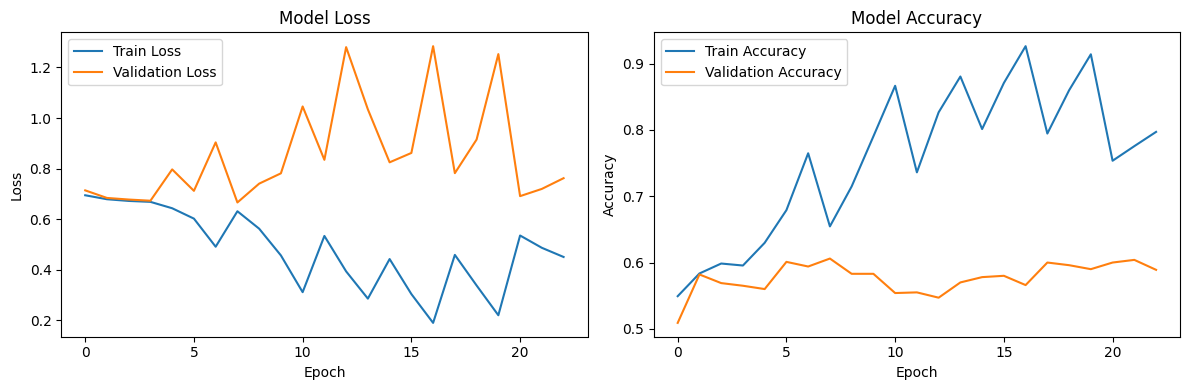

In [16]:
# 眼底画像を用いた代謝症候群分類モデル（最適化版、Early Stopping改良）
#
# 主な変更点：
# - Early Stoppingの仕様を変更：指定回数連続で更新されなければbestモデルに戻すように修正
# - その他の機能は以前と同様：
#   1. 眼底画像データセットの読み込みと前処理
#   2. データ拡張（Image Augmentation）の適用
#   3. EfficientNetV2を用いた転移学習モデルの構築
#   4. モデルのトレーニングと評価（最適化適用）
#   5. 学習率の動的調整（ReduceLROnPlateau）
#   6. 最終的な性能評価とレポート生成
#   7. トレーニング過程の可視化
#   8. 総実行時間の表示

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
import matplotlib.pyplot as plt
import time
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

# Google Driveのマウント
from google.colab import drive
drive.mount('/content/drive')

# Training settings
num_epochs = 100
patience = 15
seed = 43
consecutive_no_improvement_limit = 3  # 新しく追加：連続で改善が見られないエポック数の制限

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

# データセットクラスの定義
class FundusDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.data.iloc[idx, 8]  # METSカラムのインデックス

        if self.transform:
            image = self.transform(image)

        return image, label

# データの前処理とオーグメンテーション
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.RandomGrayscale(p=0.1),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 検証用の変換（オーグメンテーションなし）
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# データセットとデータローダーの作成
csv_file = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv"
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_224px_edge"

full_dataset = FundusDataset(csv_file, img_dir)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2, pin_memory=True)

# モデルの定義
class ModelWithDropout(nn.Module):
    def __init__(self, base_model, dropout_rate=0.5):
        super(ModelWithDropout, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(dropout_rate)

        # Get the number of features from the last layer
        in_features = self.base_model.classifier.in_features

        # Replace the classifier with a new one that includes dropout
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, 2)
        )

    def forward(self, x):
        return self.base_model(x)

# モデル、損失関数、オプティマイザーの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model = timm.create_model('efficientnetv2_rw_m.agc_in1k', pretrained=True, num_classes=2)
model = ModelWithDropout(base_model).to(device)
model = model.to(memory_format=torch.channels_last)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
scaler = torch.amp.GradScaler()

# cuDNNのオートチューナーを有効化
torch.backends.cudnn.benchmark = True

# Early Stopping クラス（改良版）
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0, consecutive_no_improvement_limit=3):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None
        self.consecutive_no_improvement = 0
        self.consecutive_no_improvement_limit = consecutive_no_improvement_limit

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            return True
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())
            self.counter = 0
            self.consecutive_no_improvement = 0
            return True
        else:
            self.counter += 1
            self.consecutive_no_improvement += 1
            if self.counter >= self.patience:
                self.early_stop = True
            if self.consecutive_no_improvement >= self.consecutive_no_improvement_limit:
                print(f"No improvement for {self.consecutive_no_improvement_limit} consecutive epochs. Reverting to best model.")
                model.load_state_dict(self.best_model)
                self.consecutive_no_improvement = 0
            return False

# トレーニング関数
def train(model, train_loader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.to(memory_format=torch.channels_last)

        # 勾配をゼロにリセット
        for param in model.parameters():
            param.grad = None

        # 混合精度での順伝播
        with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # 混合精度での逆伝播
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# 評価関数
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.to(memory_format=torch.channels_last)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# トレーニングループ
num_epochs = num_epochs
early_stopping = EarlyStopping(patience=patience, consecutive_no_improvement_limit=consecutive_no_improvement_limit)
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device, scaler)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # スケジューラの更新
    scheduler.step(val_loss)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Early Stoppingの判定とモデルの更新
    is_best = early_stopping(val_loss, model)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Epoch duration: {epoch_duration:.2f} seconds")
    print(f"Best model {'updated' if is_best else 'not updated'}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']:.6f}")
    print("-" * 40)

    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

end_time = time.time()
total_duration = end_time - start_time

print(f"Total training time: {total_duration:.2f} seconds")

# 最終評価
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.to(memory_format=torch.channels_last)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_accuracy = accuracy_score(all_labels, all_preds)
print(f"Final Accuracy: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# 訓練結果のグラフ表示
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [2]:
# 概要：
# このコードは眼底画像を用いた代謝症候群分類モデルの学習率最適化と訓練を行います。
#
# 主な特徴と機能：
# 1. 学習率finder機能：
#    - LRFinderを使用して、モデルに最適な初期学習率を自動的に特定します。
#    - 学習率vs損失のプロットを生成し、最適な学習率を視覚的に確認できます。
#
# 2. OneCycleLRスケジューラ：
#    - 1cycle政策を実装し、訓練中に学習率を動的に調整します。
#    - 高い学習率でスタートし、徐々に下げることで、高速な収束と細かい最適化を実現します。
#
# 3. Mixed Precision Training：
#    - torch.amp.autocastとGradScalerを使用して、16ビット精度と32ビット精度を組み合わせます。
#    - 訓練速度を向上させ、メモリ使用量を削減しつつ、精度を維持します。
#
# 4. Early Stopping：
#    - 検証損失が改善しない場合に訓練を早期終了し、過学習を防ぎます。
#    - 最良のモデルを保存し、必要に応じて復元します。
#
# 5. モデルアーキテクチャ：
#    - EfficientNetV2をベースモデルとして使用し、転移学習を適用します。
#    - ドロップアウト層を追加してオーバーフィッティングを抑制します。
#
# 6. 評価指標：
#    - 訓練中のエポックごとの損失と精度を計算し、表示します。
#    - 最終的な分類レポート（精度、適合率、再現率、F1スコア）を生成します。
#
# 7. 可視化：
#    - 訓練損失、検証損失、訓練精度、検証精度の推移をグラフ化します。
#    - 学習率の変化をプロットし、1cycle政策の効果を視覚的に確認できます。
#
# 8. その他の最適化：
#    - torch.channels_lastメモリフォーマットを使用して、CUDAの最適化を活用します。
#    - AdamWオプティマイザを使用し、重み減衰を適用してモデルの汎化性能を向上させます。
#
!pip install torch_lr_finder --q
!pip install timm --q
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from torch_lr_finder import LRFinder
import timm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
import time

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 学習率finderの関数
def find_lr(model, train_loader, optimizer, criterion, device):
    lr_finder = LRFinder(model, optimizer, criterion, device=device)
    lr_finder.range_test(train_loader, end_lr=10, num_iter=100)
    _, best_lr = lr_finder.plot()  # この関数は学習率vs損失のプロットも生成します
    lr_finder.reset()
    return best_lr

# モデルの定義
class ModelWithDropout(nn.Module):
    def __init__(self, base_model, dropout_rate=0.5):
        super(ModelWithDropout, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(dropout_rate)

        # Get the number of features from the last layer
        in_features = self.base_model.classifier.in_features

        # Replace the classifier with a new one that includes dropout
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, 2)
        )

    def forward(self, x):
        return self.base_model(x)

# モデル、損失関数、オプティマイザーの設定
base_model = timm.create_model('efficientnetv2_rw_m.agc_in1k', pretrained=True, num_classes=2)
model = ModelWithDropout(base_model).to(device)
model = model.to(memory_format=torch.channels_last)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# 学習率の範囲を見つける
print("Finding the best learning rate...")
best_lr = find_lr(model, train_loader, optimizer, criterion, device)
print(f"Best initial learning rate found: {best_lr:.6f}")

# OneCycleLRスケジューラの設定
scheduler = OneCycleLR(
    optimizer,
    max_lr=best_lr,
    epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,
    anneal_strategy='cos',
    final_div_factor=1000
)

# Early Stopping クラス
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0, consecutive_no_improvement_limit=3):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None
        self.consecutive_no_improvement = 0
        self.consecutive_no_improvement_limit = consecutive_no_improvement_limit

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
            return True
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.best_model = model.state_dict().copy()
            self.counter = 0
            self.consecutive_no_improvement = 0
            return True
        else:
            self.counter += 1
            self.consecutive_no_improvement += 1
            if self.counter >= self.patience:
                self.early_stop = True
            if self.consecutive_no_improvement >= self.consecutive_no_improvement_limit:
                print(f"No improvement for {self.consecutive_no_improvement_limit} consecutive epochs. Reverting to best model.")
                model.load_state_dict(self.best_model)
                self.consecutive_no_improvement = 0
            return False

# 評価関数
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.to(memory_format=torch.channels_last)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# トレーニングループ
num_epochs = 100  # 適切なエポック数を設定
early_stopping = EarlyStopping(patience=15, consecutive_no_improvement_limit=3)
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

scaler = torch.amp.GradScaler()  # Mixed Precision Training用のスケーラー

start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.to(memory_format=torch.channels_last)

        optimizer.zero_grad()

        with torch.amp.autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # スケジューラのステップを実行（バッチごと）
        scheduler.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # 現在の学習率を取得
    current_lr = optimizer.param_groups[0]['lr']

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Current learning rate: {current_lr:.6f}")
    print("-" * 40)

    # Early Stoppingの判定
    if early_stopping(val_loss, model):
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

end_time = time.time()
total_duration = end_time - start_time
print(f"Total training time: {total_duration:.2f} seconds")

# 最終評価
model.load_state_dict(early_stopping.best_model)  # 最良のモデルを読み込む
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.to(memory_format=torch.channels_last)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_accuracy = accuracy_score(all_labels, all_preds)
print(f"Final Accuracy: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# 訓練結果のグラフ表示
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history['lr'])
plt.title('Learning Rate Schedule')
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')

plt.tight_layout()
plt.show()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 26.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/214M [00:00<?, ?B/s]

Finding the best learning rate...


NameError: name 'train_loader' is not defined

###**Small datasetを用いたテスト**

In [ ]:
# 眼底画像を用いたメタボ分類
#
# このスクリプトは、眼底画像を使用して代謝症候群の二値分類を行います。
# 事前学習済みのResNet50モデルを使用し、300画像の縮小データセットで微調整を行います。
#
# 主要コンポーネント:
# 1. データ準備:
#    - 元のデータセットを300サンプルに縮小
#    - トレーニングセットと検証セットに分割
# 2. モデル:
#    - timmライブラリから事前学習済みResNet50モデルを使用
#    - 最終の全結合層を二値分類用に変更
# 3. トレーニング:
#    - カスタムトレーニングループとEarly Stoppingを実装
#    - Adamオプティマイザとクロスエントロピー損失を使用
# 4. 評価:
#    - 検証セットで最終評価を実施
#    - 精度と分類レポートを出力
# 5. 可視化:
#    - トレーニングと検証の損失/精度曲線をプロット
#
# 注意: このバージョンは、迅速なテストと反復のために縮小されたデータセットを使用しています。
#       必要に応じて、データセットのサイズ、モデルのパラメータ、トレーニング設定を調整してください。

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
import matplotlib.pyplot as plt

# データセットクラスの定義
class FundusDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.data.iloc[idx, 8]  # METSカラムのインデックス

        if self.transform:
            image = self.transform(image)

        return image, label

# データの前処理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# データセットとデータローダーの作成
csv_file = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv"
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_224px"

# CSVファイルを読み込み、最初の300行を抽出
full_data = pd.read_csv(csv_file)
reduced_data = full_data.head(300)
reduced_csv_file = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train_reduced.csv"
reduced_data.to_csv(reduced_csv_file, index=False)

# 縮小されたデータセットを使用
dataset = FundusDataset(reduced_csv_file, img_dir, transform=transform)
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

print(f"Total samples in reduced dataset: {len(dataset)}")
print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")

# モデルの定義
class ResNet50Model(nn.Module):
    def __init__(self):
        super(ResNet50Model, self).__init__()
        self.resnet = timm.create_model('resnet50', pretrained=True)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 2)  # 2クラス分類

    def forward(self, x):
        return self.resnet(x)

# モデル、損失関数、オプティマイザーの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# トレーニング関数
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# 評価関数
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Early Stopping クラス
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# トレーニングループ
num_epochs = 50
early_stopping = EarlyStopping(patience=10)
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print("-" * 40)

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# 最終評価
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_accuracy = accuracy_score(all_labels, all_preds)
print(f"Final Accuracy: {final_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# 訓練結果のグラフ表示
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#**周辺項目から攻めるバージョン**


-----------
###説明変数

age: 年齢

AC: 腹囲

SBP: 収縮期血圧

DBP: 拡張期血圧

HDLC: HDLコレステロール

TG: 中性脂肪

BS: 血糖

---------------

###目的変数

METS: メタボリックシンドロームの有無

---------------

1. label_train.csvから標準化した説明変数をピックアップする

2. ResNet50で、7つの説明変数を同時に回帰するモデルを作成する。Lossは最小二乗誤差とする

3. まずはこのモデルがうまく作成できるかを検討

4. ある程度モデルの精度が上がったら、7つの変数からNGBoostを用いてMETsを予測するモデルを結合して、METsを目的変数としてファインチューニングする


In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 82.5 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
import matplotlib.pyplot as plt
!pip install ranger-adabelief==0.1.0
from ranger_adabelief import RangerAdaBelief

# データセットクラスの定義
class FundusDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        # 説明変数の標準化
        self.scaler = StandardScaler()
        self.features = ['age', 'AC', 'SBP', 'DBP', 'HDLC', 'TG', 'BS']
        self.data[self.features] = self.scaler.fit_transform(self.data[self.features])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')

        # 説明変数を取得
        features = self.data.iloc[idx][self.features].values.astype(np.float32)

        # METSラベルを取得
        mets_label = self.data.iloc[idx]['METS']

        if self.transform:
            image = self.transform(image)

        return image, features, mets_label

# データの前処理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# データセットとデータローダーの作成
csv_file = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv"
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_224px"

full_dataset = FundusDataset(csv_file, img_dir, transform=transform)
train_dataset, val_dataset = train_test_split(full_dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# マルチ出力回帰モデルの定義
# class MultiOutputRegression(nn.Module):
#     def __init__(self):
#         super(MultiOutputRegression, self).__init__()
#         self.resnet = timm.create_model('resnet50', pretrained=True)
#         in_features = self.resnet.fc.in_features
#         self.resnet.fc = nn.Identity()  # Remove the final fully connected layer

#         self.regression_head = nn.Sequential(
#             nn.Linear(in_features, 256),
#             nn.ReLU(),
#             nn.Linear(256, 7)  # 7 outputs for regression
#         )

#     def forward(self, x):
#         features = self.resnet(x)
#         return self.regression_head(features)

class MultiOutputRegression(nn.Module):
    def __init__(self):
        super(MultiOutputRegression, self).__init__()
        self.repvgg = timm.create_model('repvgg_a0.rvgg_in1k', pretrained=True)
        in_features = self.repvgg.head.fc.in_features
        self.repvgg.head.fc = nn.Identity()  # Remove the final fully connected layer

        self.regression_head = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 7)  # 7 outputs for regression
        )

    def forward(self, x):
        features = self.repvgg(x)
        return self.regression_head(features)

# モデル、損失関数、オプティマイザーの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiOutputRegression().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0002)
optimizer_ft = RangerAdaBelief(model_ft.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999), weight_decouple = True)


# トレーニングループ
num_epochs = 50
history = {'train_loss': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, features, _ in train_loader:
        images, features = images.to(device), features.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, features)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, features, _ in val_loader:
            images, features = images.to(device), features.to(device)
            outputs = model(images)
            loss = criterion(outputs, features)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# 学習曲線のプロット
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# モデルの評価
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for images, features, _ in val_loader:
        images, features = images.to(device), features.to(device)
        outputs = model(images)
        all_preds.extend(outputs.cpu().numpy())
        all_true.extend(features.cpu().numpy())

all_preds = np.array(all_preds)
all_true = np.array(all_true)

# R-squared score for each feature
from sklearn.metrics import r2_score

feature_names = ['age', 'AC', 'SBP', 'DBP', 'HDLC', 'TG', 'BS']
for i, feature in enumerate(feature_names):
    r2 = r2_score(all_true[:, i], all_preds[:, i])
    print(f"R-squared score for {feature}: {r2:.4f}")

# Scatter plots for each feature
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, feature in enumerate(feature_names):
    axes[i].scatter(all_true[:, i], all_preds[:, i], alpha=0.5)
    axes[i].plot([all_true[:, i].min(), all_true[:, i].max()], [all_true[:, i].min(), all_true[:, i].max()], 'r--', lw=2)
    axes[i].set_xlabel(f'True {feature}')
    axes[i].set_ylabel(f'Predicted {feature}')
    axes[i].set_title(f'{feature}')

plt.tight_layout()
plt.show()

In [ ]:
# 必要なライブラリのインストール
!pip install timm
!pip install ranger-adabelief==0.1.0

# Google Driveのマウント
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
import matplotlib.pyplot as plt
from ranger_adabelief import RangerAdaBelief

# データセットクラスの定義
class FundusDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        # 説明変数の標準化
        self.scaler = StandardScaler()
        self.features = ['age', 'AC', 'SBP', 'DBP', 'HDLC', 'TG', 'BS']
        self.data[self.features] = self.scaler.fit_transform(self.data[self.features])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')

        # 説明変数を取得
        features = self.data.iloc[idx][self.features].values.astype(np.float32)

        # METSラベルを取得
        mets_label = self.data.iloc[idx]['METS']

        if self.transform:
            image = self.transform(image)

        return image, features, mets_label

# データの前処理とオーグメンテーション
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 検証用の変換（オーグメンテーションなし）
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# データセットとデータローダーの作成
csv_file = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv"
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_224px"

full_dataset = FundusDataset(csv_file, img_dir)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# RepVGG A0を使用したマルチ出力回帰モデルの定義
class MultiOutputRegression(nn.Module):
    def __init__(self):
        super(MultiOutputRegression, self).__init__()
        self.repvgg = timm.create_model('repvgg_a0.rvgg_in1k', pretrained=True)
        in_features = self.repvgg.head.fc.in_features
        self.repvgg.head.fc = nn.Identity()  # Remove the final fully connected layer

        self.regression_head = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 7)  # 7 outputs for regression
        )

    def forward(self, x):
        features = self.repvgg(x)
        return self.regression_head(features)

# モデル、損失関数、オプティマイザーの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiOutputRegression().to(device)
criterion = nn.MSELoss()
optimizer = RangerAdaBelief(model.parameters(), lr=1e-3, eps=1e-12, betas=(0.9,0.999), weight_decouple=True)

# トレーニングループ
num_epochs = 50
history = {'train_loss': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, features, _ in train_loader:
        images, features = images.to(device), features.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, features)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, features, _ in val_loader:
            images, features = images.to(device), features.to(device)
            outputs = model(images)
            loss = criterion(outputs, features)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# 学習曲線のプロット
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# モデルの評価
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for images, features, _ in val_loader:
        images, features = images.to(device), features.to(device)
        outputs = model(images)
        all_preds.extend(outputs.cpu().numpy())
        all_true.extend(features.cpu().numpy())

all_preds = np.array(all_preds)
all_true = np.array(all_true)

# R-squared score for each feature
from sklearn.metrics import r2_score

feature_names = ['age', 'AC', 'SBP', 'DBP', 'HDLC', 'TG', 'BS']
for i, feature in enumerate(feature_names):
    r2 = r2_score(all_true[:, i], all_preds[:, i])
    print(f"R-squared score for {feature}: {r2:.4f}")

# Scatter plots for each feature
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, feature in enumerate(feature_names):
    axes[i].scatter(all_true[:, i], all_preds[:, i], alpha=0.5)
    axes[i].plot([all_true[:, i].min(), all_true[:, i].max()], [all_true[:, i].min(), all_true[:, i].max()], 'r--', lw=2)
    axes[i].set_xlabel(f'True {feature}')
    axes[i].set_ylabel(f'Predicted {feature}')
    axes[i].set_title(f'{feature}')

plt.tight_layout()
plt.show()

# Save the model
torch.save(model.state_dict(), '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/repvgg_regression_model.pth')
print("Model saved successfully.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 61.1 MB/s eta 0:00:00
Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/36.6M [00:00<?, ?B/s]

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


### 上位1/4と下位1/4を見分けられるか？？

SBP: accuracy 0.57

In [ ]:
# 必要なライブラリのインストール
!pip install timm --q
!pip install ranger-adabelief==0.1.0 --q

# Google Driveのマウント
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
import matplotlib.pyplot as plt
import time
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau


# Load the uploaded CSV file
file_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv'
data = pd.read_csv(file_path)

# Check the columns in the CSV to understand the structure
data.columns

######################
## 計算する項目を指定
column = 'DBP'
######################

# Calculate the 25th and 75th percentiles for the SBP column
sbp_25th = data[column].quantile(0.25)
sbp_75th = data[column].quantile(0.75)

# Filter the data for filenames where SBP is in the lower 1/4 and upper 1/4
lower_quartile = data[data[column] <= sbp_25th]['filename'].tolist()
upper_quartile = data[data[column] >= sbp_75th]['filename'].tolist()

print(f"lower_quartile: {len(lower_quartile)}, upper_quartile: {len(upper_quartile)}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
lower_quartile: 1312, upper_quartile: 1309


In [ ]:
# Filter the dataset to only include rows with filenames in the lower and upper quartiles
selected_filenames = lower_quartile + upper_quartile
filtered_data = data[data['filename'].isin(selected_filenames)]

# Split the filtered dataset into training and validation sets
train_data, val_data = train_test_split(filtered_data, test_size=0.2, random_state=42)

# Save the filtered train and validation datasets to new CSV files for model use
filtered_train_csv = '/content/filtered_train.csv'
filtered_val_csv = '/content/filtered_val.csv'

train_data.to_csv(filtered_train_csv, index=False)
val_data.to_csv(filtered_val_csv, index=False)

# Now we will set up the deep learning dataset and dataloaders using these filtered datasets
class FilteredFundusDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        # Assuming 'METS' is the label as in the original model script
        label = self.data.iloc[idx, 8]

        if self.transform:
            image = self.transform(image)

        return image, label

# データの前処理とオーグメンテーション
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 検証用の変換（オーグメンテーションなし）
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Early Stopping クラス
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Paths for the filtered datasets
train_csv_file = filtered_train_csv
val_csv_file = filtered_val_csv
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_224px"

# Create dataset objects for the filtered data
train_dataset_filtered = FilteredFundusDataset(train_csv_file, img_dir, transform_train)
val_dataset_filtered = FilteredFundusDataset(val_csv_file, img_dir, transform_val)

# Create data loaders for the filtered datasets
train_loader_filtered = DataLoader(train_dataset_filtered, batch_size=8, shuffle=True)
val_loader_filtered = DataLoader(val_dataset_filtered, batch_size=8, shuffle=False)

# The filtered datasets are now ready. You can now use the existing deep learning model code to train and evaluate the model.
filtered_train_csv, filtered_val_csv


('/content/filtered_train.csv', '/content/filtered_val.csv')

In [ ]:
# We will now proceed with training the model using the filtered data.
# Reusing the model and training functions from the provided deep learning code

# Set device for training (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model setup (using the selected model: RepVGG A0)
# モデル定義の一部にドロップアウトを追加
model = nn.Sequential(
    timm.create_model('repvgg_a0.rvgg_in1k', pretrained=True, num_classes=1000),
    nn.Dropout(0.5),
    nn.Linear(1000, 2)
).to(device)


# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.002)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


# Initialize training
num_epochs = 200
patience = 10
early_stopping = EarlyStopping(patience=patience)
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    epoch_start_time = time.time()

    train_loss, train_acc = train(model, train_loader_filtered, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader_filtered, criterion, device)
    scheduler.step(val_loss)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Epoch duration: {epoch_duration:.2f} seconds")
    print("-" * 40)

    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

end_time = time.time()
total_duration = end_time - start_time

# Final evaluation on validation set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader_filtered:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_accuracy = accuracy_score(all_labels, all_preds)
classification_rep = classification_report(all_labels, all_preds)

final_accuracy, classification_rep


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50
Train Loss: 0.9079, Train Acc: 0.5162
Val Loss: 0.7046, Val Acc: 0.5124
Epoch duration: 33.75 seconds
----------------------------------------
Epoch 2/50
Train Loss: 0.7191, Train Acc: 0.5367
Val Loss: 0.7437, Val Acc: 0.5410
Epoch duration: 31.30 seconds
----------------------------------------
Epoch 3/50
Train Loss: 0.7147, Train Acc: 0.5396
Val Loss: 0.6830, Val Acc: 0.5371
Epoch duration: 32.02 seconds
----------------------------------------
Epoch 4/50
Train Loss: 0.7222, Train Acc: 0.5301
Val Loss: 0.8476, Val Acc: 0.5410
Epoch duration: 30.97 seconds
----------------------------------------
Epoch 5/50
Train Loss: 0.7143, Train Acc: 0.5382
Val Loss: 0.6599, Val Acc: 0.6171
Epoch duration: 31.07 seconds
----------------------------------------
Epoch 6/50
Train Loss: 0.6941, Train Acc: 0.5630
Val Loss: 0.6614, Val Acc: 0.5543
Epoch duration: 30.70 seconds
----------------------------------------
Epoch 7/50
Train Loss: 0.7020, Train Acc: 0.5592
Val Loss: 0.6611, Val Acc: 

(0.6476190476190476,
 '              precision    recall  f1-score   support\n\n           0       0.69      0.63      0.66       284\n           1       0.60      0.67      0.64       241\n\n    accuracy                           0.65       525\n   macro avg       0.65      0.65      0.65       525\nweighted avg       0.65      0.65      0.65       525\n')

### 上位1/4と下位1/4を見分けられるか？？

Accuracy

Age: 0.64

AC: 0.63

SBP: 0.66

DBP: 0.63

HDLC: 0.55

TG: 0.62





In [ ]:
"""
このスクリプトは眼底画像と代謝関連データを用いた深層学習モデルの作成と学習を行います。
主な機能：
1. 必要なライブラリのインポートとセットアップ
2. Google Driveのマウントとデータの読み込み
3. カスタムデータセットクラスの定義
4. データ拡張とテンソル変換の設定
5. モデルのトレーニングと評価関数の定義
6. 早期終了機能の実装
7. 特定のカラムに対するモデル作成・トレーニング関数
   - 四分位数に基づくデータフィルタリング
   - データセットの分割とデータローダーの作成
   - モデルのセットアップ、損失関数、最適化アルゴリズムの定義
   - トレーニングループ（早期終了を含む）
8. メインループ：各カラム（年齢、AC、SBP、DBP、HDLC、TG、BS）に対して
   モデルを作成・トレーニングし、結果を保存

このスクリプトは、各代謝指標の上位25%と下位25%のデータを使用して
バイナリ分類モデルを学習し、眼底画像からこれらの代謝異常を
予測することを目的としています。
"""

このコメントアウトは、スクリプト全体の目的と主な機能を簡潔に説明しています。

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Google Driveのマウント
from google.colab import drive
drive.mount('/content/drive')

# 必要なライブラリのインストール
!pip install timm --quiet
!pip install ranger-adabelief==0.1.0 --quiet

# Set device for training (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the CSV file
file_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv'
data = pd.read_csv(file_path)

# Define the columns to process
columns = ['age', 'AC', 'SBP', 'DBP', 'HDLC', 'TG', 'BS']

# Dataset class
class FilteredFundusDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        label = self.data.iloc[idx, 8]  # Assuming 'METS' is the label as in the original model script

        if self.transform:
            image = self.transform(image)

        return image, label

# Data transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Function to create and train model for a specific column
def create_and_train_model(column):
    # Calculate the 25th and 75th percentiles for the column
    lower_quartile = data[column].quantile(0.25)
    upper_quartile = data[column].quantile(0.75)

    # Filter the data for filenames where the column value is in the lower 1/4 and upper 1/4
    lower_quartile_files = data[data[column] <= lower_quartile]['filename'].tolist()
    upper_quartile_files = data[data[column] >= upper_quartile]['filename'].tolist()

    # Combine the filtered filenames
    selected_filenames = lower_quartile_files + upper_quartile_files
    filtered_data = data[data['filename'].isin(selected_filenames)]

    # Split the filtered dataset into training and validation sets
    train_data, val_data = train_test_split(filtered_data, test_size=0.2, random_state=42)

    # Save the filtered train and validation datasets to new CSV files
    filtered_train_csv = f'/content/filtered_train_{column}.csv'
    filtered_val_csv = f'/content/filtered_val_{column}.csv'
    train_data.to_csv(filtered_train_csv, index=False)
    val_data.to_csv(filtered_val_csv, index=False)

    # Create dataset objects for the filtered data
    train_dataset = FilteredFundusDataset(filtered_train_csv, img_dir, transform_train)
    val_dataset = FilteredFundusDataset(filtered_val_csv, img_dir, transform_val)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    # Model setup
    model = nn.Sequential(
        timm.create_model('repvgg_a0.rvgg_in1k', pretrained=True, num_classes=1000),
        nn.Dropout(0.5),
        nn.Linear(1000, 2)
    ).to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.002)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    # Training loop
    num_epochs = 200
    patience = 10
    early_stopping = EarlyStopping(patience=patience)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return model, history

# Set the image directory
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_224px"

# Main loop to process each column
for column in columns:
    print(f"Processing column: {column}")
    model, history = create_and_train_model(column)

    # Save the model
    save_path = f"/content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/quartile/model_{column}.pth"
    torch.save(model.state_dict(), save_path)
    print(f"Model for {column} saved to {save_path}")

    # Save the history as CSV
    history_df = pd.DataFrame(history)
    history_path = os.path.join(save_path, f"history_{column}.csv")
    history_df.to_csv(history_path, index=False)
    print(f"Training history for {column} saved to {history_path}")

    print(f"Completed processing for {column}")
    print("-" * 40)

print("All columns processed and models saved.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 61.0 MB/s eta 0:00:00
Mounted at /content/drive
Processing column: age


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/36.6M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/200
Train Loss: 1.1398, Train Acc: 0.5171
Val Loss: 1.0725, Val Acc: 0.5232
Epoch 2/200
Train Loss: 0.7312, Train Acc: 0.5152
Val Loss: 0.6960, Val Acc: 0.5058
Epoch 3/200
Train Loss: 0.7310, Train Acc: 0.5331
Val Loss: 0.6908, Val Acc: 0.5290
Epoch 4/200
Train Loss: 0.7292, Train Acc: 0.5200
Val Loss: 0.6767, Val Acc: 0.5425
Epoch 5/200
Train Loss: 0.7207, Train Acc: 0.5321
Val Loss: 0.6842, Val Acc: 0.5328
Epoch 6/200
Train Loss: 0.7250, Train Acc: 0.5162
Val Loss: 0.6721, Val Acc: 0.6062
Epoch 7/200
Train Loss: 0.7116, Train Acc: 0.5321
Val Loss: 0.7278, Val Acc: 0.5541
Epoch 8/200
Train Loss: 0.6989, Train Acc: 0.5509
Val Loss: 0.7527, Val Acc: 0.6004
Epoch 9/200
Train Loss: 0.7124, Train Acc: 0.5437
Val Loss: 0.6861, Val Acc: 0.5309
Epoch 10/200
Train Loss: 0.6897, Train Acc: 0.5519
Val Loss: 0.7061, Val Acc: 0.5251
Epoch 11/200
Train Loss: 0.6990, Train Acc: 0.5408
Val Loss: 0.7380, Val Acc: 0.5251
Epoch 12/200
Train Loss: 0.7032, Train Acc: 0.5674
Val Loss: 0.6737, Val A

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/200
Train Loss: 1.0656, Train Acc: 0.5338
Val Loss: 0.7459, Val Acc: 0.5258
Epoch 2/200
Train Loss: 0.7121, Train Acc: 0.5586
Val Loss: 0.6932, Val Acc: 0.5298
Epoch 3/200
Train Loss: 0.6983, Train Acc: 0.5616
Val Loss: 0.6921, Val Acc: 0.5337
Epoch 4/200
Train Loss: 0.7244, Train Acc: 0.5412
Val Loss: 0.7124, Val Acc: 0.5615
Epoch 5/200
Train Loss: 0.7087, Train Acc: 0.5492
Val Loss: 0.7014, Val Acc: 0.5615
Epoch 6/200
Train Loss: 0.7364, Train Acc: 0.5392
Val Loss: 0.6882, Val Acc: 0.5615
Epoch 7/200
Train Loss: 0.7033, Train Acc: 0.5487
Val Loss: 0.7554, Val Acc: 0.5615
Epoch 8/200
Train Loss: 0.6961, Train Acc: 0.5655
Val Loss: 0.6886, Val Acc: 0.5615
Epoch 9/200
Train Loss: 0.6948, Train Acc: 0.5745
Val Loss: 0.7398, Val Acc: 0.5615
Epoch 10/200
Train Loss: 0.6961, Train Acc: 0.5531
Val Loss: 0.6879, Val Acc: 0.5615
Epoch 11/200
Train Loss: 0.6932, Train Acc: 0.5675
Val Loss: 1.8177, Val Acc: 0.5615
Epoch 12/200
Train Loss: 0.6940, Train Acc: 0.5531
Val Loss: 0.7184, Val A

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/200
Train Loss: 1.0266, Train Acc: 0.5116
Val Loss: 0.7275, Val Acc: 0.5590
Epoch 2/200
Train Loss: 0.7159, Train Acc: 0.5252
Val Loss: 0.7708, Val Acc: 0.5551
Epoch 3/200
Train Loss: 0.7114, Train Acc: 0.5353
Val Loss: 0.6925, Val Acc: 0.5667
Epoch 4/200
Train Loss: 0.7232, Train Acc: 0.5271
Val Loss: 0.6934, Val Acc: 0.5590
Epoch 5/200
Train Loss: 0.7042, Train Acc: 0.5518
Val Loss: 0.6952, Val Acc: 0.5609
Epoch 6/200
Train Loss: 0.7015, Train Acc: 0.5499
Val Loss: 0.6528, Val Acc: 0.6383
Epoch 7/200
Train Loss: 0.6983, Train Acc: 0.5528
Val Loss: 0.6624, Val Acc: 0.6170
Epoch 8/200
Train Loss: 0.6925, Train Acc: 0.5474
Val Loss: 0.6666, Val Acc: 0.5880
Epoch 9/200
Train Loss: 0.6910, Train Acc: 0.5653
Val Loss: 0.7880, Val Acc: 0.5841
Epoch 10/200
Train Loss: 0.6986, Train Acc: 0.5503
Val Loss: 0.6786, Val Acc: 0.5764
Epoch 11/200
Train Loss: 0.6975, Train Acc: 0.5687
Val Loss: 0.6504, Val Acc: 0.6422
Epoch 12/200
Train Loss: 0.6951, Train Acc: 0.5649
Val Loss: 0.6500, Val A

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/200
Train Loss: 0.9607, Train Acc: 0.5091
Val Loss: 0.8096, Val Acc: 0.5410
Epoch 2/200
Train Loss: 0.7456, Train Acc: 0.5315
Val Loss: 0.6875, Val Acc: 0.5638
Epoch 3/200
Train Loss: 0.7549, Train Acc: 0.5134
Val Loss: 0.6877, Val Acc: 0.5410
Epoch 4/200
Train Loss: 0.7298, Train Acc: 0.5243
Val Loss: 0.6768, Val Acc: 0.5733
Epoch 5/200
Train Loss: 0.7452, Train Acc: 0.5115
Val Loss: 0.7639, Val Acc: 0.4590
Epoch 6/200
Train Loss: 0.7050, Train Acc: 0.5324
Val Loss: 0.6852, Val Acc: 0.5676
Epoch 7/200
Train Loss: 0.7135, Train Acc: 0.5224
Val Loss: 0.6509, Val Acc: 0.6152
Epoch 8/200
Train Loss: 0.7110, Train Acc: 0.5363
Val Loss: 0.6709, Val Acc: 0.5810
Epoch 9/200
Train Loss: 0.7104, Train Acc: 0.5472
Val Loss: 0.7491, Val Acc: 0.4590
Epoch 10/200
Train Loss: 0.7190, Train Acc: 0.5358
Val Loss: 0.6913, Val Acc: 0.5410
Epoch 11/200
Train Loss: 0.7125, Train Acc: 0.5200
Val Loss: 0.6929, Val Acc: 0.5410
Epoch 12/200
Train Loss: 0.7171, Train Acc: 0.5186
Val Loss: 0.7391, Val A

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/200
Train Loss: 1.1638, Train Acc: 0.5154
Val Loss: 1.1115, Val Acc: 0.4887
Epoch 2/200
Train Loss: 0.7337, Train Acc: 0.5087
Val Loss: 0.8904, Val Acc: 0.4943
Epoch 3/200
Train Loss: 0.7184, Train Acc: 0.5144
Val Loss: 0.7465, Val Acc: 0.5075
Epoch 4/200
Train Loss: 0.7235, Train Acc: 0.5149
Val Loss: 0.7350, Val Acc: 0.4962
Epoch 5/200
Train Loss: 0.7163, Train Acc: 0.5106
Val Loss: 0.7800, Val Acc: 0.5132
Epoch 6/200
Train Loss: 0.7352, Train Acc: 0.5102
Val Loss: 0.7507, Val Acc: 0.4830
Epoch 7/200
Train Loss: 0.7198, Train Acc: 0.5305
Val Loss: 0.7774, Val Acc: 0.5019
Epoch 8/200
Train Loss: 0.7218, Train Acc: 0.5050
Val Loss: 0.7059, Val Acc: 0.5038
Epoch 9/200
Train Loss: 0.7152, Train Acc: 0.5338
Val Loss: 0.6834, Val Acc: 0.5585
Epoch 10/200
Train Loss: 0.7036, Train Acc: 0.5470
Val Loss: 0.7165, Val Acc: 0.5377
Epoch 11/200
Train Loss: 0.7059, Train Acc: 0.5536
Val Loss: 0.7293, Val Acc: 0.4811
Epoch 12/200
Train Loss: 0.7114, Train Acc: 0.5338
Val Loss: 0.7308, Val A

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/200
Train Loss: 1.2906, Train Acc: 0.4980
Val Loss: 0.8541, Val Acc: 0.5138
Epoch 2/200
Train Loss: 0.7287, Train Acc: 0.4980
Val Loss: 0.6923, Val Acc: 0.5553
Epoch 3/200
Train Loss: 0.7127, Train Acc: 0.5247
Val Loss: 0.6792, Val Acc: 0.5771
Epoch 4/200
Train Loss: 0.7233, Train Acc: 0.5282
Val Loss: 0.7117, Val Acc: 0.5613
Epoch 5/200
Train Loss: 0.7044, Train Acc: 0.5474
Val Loss: 0.7209, Val Acc: 0.5119
Epoch 6/200
Train Loss: 0.7023, Train Acc: 0.5440
Val Loss: 0.6725, Val Acc: 0.5791
Epoch 7/200
Train Loss: 0.7096, Train Acc: 0.5375
Val Loss: 0.6747, Val Acc: 0.5810
Epoch 8/200
Train Loss: 0.6944, Train Acc: 0.5311
Val Loss: 0.6738, Val Acc: 0.5830
Epoch 9/200
Train Loss: 0.6943, Train Acc: 0.5568
Val Loss: 0.9884, Val Acc: 0.4862
Epoch 10/200
Train Loss: 0.6999, Train Acc: 0.5445
Val Loss: 0.7202, Val Acc: 0.5652
Epoch 11/200
Train Loss: 0.6961, Train Acc: 0.5548
Val Loss: 0.6723, Val Acc: 0.6126
Epoch 12/200
Train Loss: 0.6849, Train Acc: 0.5657
Val Loss: 0.7343, Val A

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/200
Train Loss: 0.9251, Train Acc: 0.5032
Val Loss: 0.6884, Val Acc: 0.5204
Epoch 2/200
Train Loss: 0.7228, Train Acc: 0.5371
Val Loss: 0.7030, Val Acc: 0.4630
Epoch 3/200
Train Loss: 0.7415, Train Acc: 0.5116
Val Loss: 0.7216, Val Acc: 0.5426
Epoch 4/200
Train Loss: 0.7197, Train Acc: 0.5385
Val Loss: 0.7039, Val Acc: 0.5426
Epoch 5/200
Train Loss: 0.7174, Train Acc: 0.5390
Val Loss: 0.7086, Val Acc: 0.4963
Epoch 6/200
Train Loss: 0.7262, Train Acc: 0.5246
Val Loss: 0.6867, Val Acc: 0.5333
Epoch 7/200
Train Loss: 0.7288, Train Acc: 0.5167
Val Loss: 0.7029, Val Acc: 0.4648
Epoch 8/200
Train Loss: 0.7050, Train Acc: 0.5255
Val Loss: 0.6864, Val Acc: 0.5556
Epoch 9/200
Train Loss: 0.6946, Train Acc: 0.5496
Val Loss: 0.6804, Val Acc: 0.6056
Epoch 10/200
Train Loss: 0.6898, Train Acc: 0.5557
Val Loss: 0.7247, Val Acc: 0.5426
Epoch 11/200
Train Loss: 0.6975, Train Acc: 0.5404
Val Loss: 0.7536, Val Acc: 0.5426
Epoch 12/200
Train Loss: 0.6928, Train Acc: 0.5557
Val Loss: 0.6923, Val A

In [ ]:
"""
このスクリプトは眼底画像を用いて代謝関連データの回帰分析を行う深層学習モデルを作成・学習します。
主な機能：
1. 必要なライブラリのインポートとGPU設定
2. CSVファイルからのデータ読み込みと処理対象カラムの定義
3. 回帰分析用のカスタムデータセットクラスの定義（StandardScalerを使用）
4. データ拡張とテンソル変換の設定
5. モデルのトレーニングと評価関数の定義
6. 早期終了機能の実装
7. 特定のカラムに対する回帰モデル作成・トレーニング関数
   - データセットの分割とデータローダーの作成
   - 事前学習済みモデルの読み込みと回帰用への修正
   - 損失関数（MSE）、最適化アルゴリズム、学習率スケジューラの定義. RepVGGA0, RangerAdaBrief, Dropout
   - トレーニングループ（早期終了を含む）
8. メインループ：各カラム（年齢、AC、SBP、DBP、HDLC、TG、BS）に対して
   回帰モデルを作成・トレーニングし、結果を保存

このスクリプトは、先行して学習された分類モデルを基に、
眼底画像から直接各代謝指標の値を予測する回帰モデルを
ファインチューニングすることを目的としています。
"""
# 必要なライブラリのインストール
!pip install timm --quiet
!pip install ranger-adabelief==0.1.0 --quiet

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import timm
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Google Driveのマウント
from google.colab import drive
drive.mount('/content/drive')

# Set device for training (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the CSV file
file_path = '/content/drive/MyDrive/Deep_learning/Fundus_metabolic/label_train.csv'
data = pd.read_csv(file_path)

# Define the columns to process
#columns = ['age', 'AC', 'SBP', 'DBP', 'HDLC', 'TG', 'BS']
columns = ['DBP', 'HDLC', 'TG', 'BS']


# Dataset class for regression
class FundusRegressionDataset(Dataset):
    def __init__(self, csv_file, img_dir, target_column, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_column = target_column
        self.scaler = StandardScaler()
        self.data[target_column] = self.scaler.fit_transform(self.data[[target_column]])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        target = self.data.iloc[idx][self.target_column]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(target, dtype=torch.float32)

# Data transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    return epoch_loss

# Evaluation function
def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, targets)

            running_loss += loss.item()

    epoch_loss = running_loss / len(val_loader)
    return epoch_loss

# Early Stopping class
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Function to create and train regression model for a specific column
def create_and_train_regression_model(column):
    # Split the dataset into training and validation sets
    train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

    # Save the train and validation datasets to new CSV files
    train_csv = f'/content/train_{column}.csv'
    val_csv = f'/content/val_{column}.csv'
    train_data.to_csv(train_csv, index=False)
    val_data.to_csv(val_csv, index=False)

    # Create dataset objects
    train_dataset = FundusRegressionDataset(train_csv, img_dir, column, transform_train)
    val_dataset = FundusRegressionDataset(val_csv, img_dir, column, transform_val)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    # Load the pre-trained model
    pretrained_model_path = f"/content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/quartile/model_{column}.pth"
    pretrained_model = nn.Sequential(
        timm.create_model('repvgg_a0.rvgg_in1k', pretrained=True, num_classes=1000),
        nn.Dropout(0.5),
        nn.Linear(1000, 2)
    )
    pretrained_model.load_state_dict(torch.load(pretrained_model_path))

    # Modify the model for regression
    model = nn.Sequential(
        *list(pretrained_model.children())[:-1],  # Remove the last layer
        nn.Linear(1000, 1)  # Add a new layer for regression
    ).to(device)

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    # Training loop
    num_epochs = 100
    patience = 10
    early_stopping = EarlyStopping(patience=patience)
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        val_loss = evaluate(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")

        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return model, history

# Set the image directory
img_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/images_224px"

# Set the save directory for the new models
save_dir = "/content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/regression_finetuned_from_quartile"
os.makedirs(save_dir, exist_ok=True)

import pandas as pd

# Main loop to process each column
for column in columns:
    print(f"Processing column: {column}")
    model, history = create_and_train_regression_model(column)

    # Save the model
    save_path = os.path.join(save_dir, f"model_{column}.pth")
    torch.save(model.state_dict(), save_path)
    print(f"Model for {column} saved to {save_path}")

    # Save the history as CSV
    history_df = pd.DataFrame(history)
    history_path = os.path.join(save_dir, f"history_{column}.csv")
    history_df.to_csv(history_path, index=False)
    print(f"Training history for {column} saved to {history_path}")

    print(f"Completed processing for {column}")
    print("-" * 40)

print("All columns processed and models saved.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Processing column: DBP


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/36.6M [00:00<?, ?B/s]

<ipython-input-4-071268bee341>:176: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_model.load_state_dict(torch.load(pretrained_model_path))
/usr/local/lib/python3.

Epoch 1/100
Train Loss: 0.9883
Val Loss: 0.9438
Epoch 2/100
Train Loss: 0.9842
Val Loss: 0.9576
Epoch 3/100
Train Loss: 0.9872
Val Loss: 1.1142
Epoch 4/100
Train Loss: 0.9718
Val Loss: 0.9381
Epoch 5/100
Train Loss: 0.9749
Val Loss: 0.9959
Epoch 6/100
Train Loss: 0.9838
Val Loss: 0.9545
Epoch 7/100
Train Loss: 0.9631
Val Loss: 0.9787
Epoch 8/100
Train Loss: 0.9542
Val Loss: 0.9291
Epoch 9/100
Train Loss: 0.9574
Val Loss: 0.9138
Epoch 10/100
Train Loss: 0.9586
Val Loss: 0.9365
Epoch 11/100
Train Loss: 0.9576
Val Loss: 0.9747
Epoch 12/100
Train Loss: 0.9471
Val Loss: 0.9297
Epoch 13/100
Train Loss: 0.9499
Val Loss: 0.9296
Epoch 14/100
Train Loss: 0.9406
Val Loss: 0.9026
Epoch 15/100
Train Loss: 0.9431
Val Loss: 0.9459
Epoch 16/100
Train Loss: 0.9328
Val Loss: 0.9722
Epoch 17/100
Train Loss: 0.9381
Val Loss: 0.9043
Epoch 18/100
Train Loss: 0.9362
Val Loss: 0.8991
Epoch 19/100
Train Loss: 0.9375
Val Loss: 0.9170
Epoch 20/100
Train Loss: 0.9351
Val Loss: 0.8959
Epoch 21/100
Train Loss: 0.94

<ipython-input-4-071268bee341>:176: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_model.load_state_dict(torch.load(pretrained_model_path))
/usr/local/lib/python3.

Epoch 1/100
Train Loss: 1.0437
Val Loss: 1.0487
Epoch 2/100
Train Loss: 1.0220
Val Loss: 1.0215
Epoch 3/100
Train Loss: 1.0158
Val Loss: 1.0059
Epoch 4/100
Train Loss: 1.0186
Val Loss: 0.9998
Epoch 5/100
Train Loss: 1.0292
Val Loss: 1.0002
Epoch 6/100
Train Loss: 1.0143
Val Loss: 1.0201
Epoch 7/100
Train Loss: 1.0101
Val Loss: 1.0013
Epoch 8/100
Train Loss: 1.0127
Val Loss: 1.0015
Epoch 9/100
Train Loss: 1.0083
Val Loss: 1.0029
Epoch 10/100
Train Loss: 1.0120
Val Loss: 1.0153
Epoch 11/100
Train Loss: 1.0060
Val Loss: 1.0147
Epoch 12/100
Train Loss: 1.0039
Val Loss: 1.0192
Epoch 13/100
Train Loss: 1.0049
Val Loss: 1.0196
Epoch 14/100
Train Loss: 1.0054
Val Loss: 1.0161
Early stopping triggered
Model for HDLC saved to /content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/regression_finetuned_from_quartile/model_HDLC.pth
Training history for HDLC saved to /content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/regression_finetuned_from_quartile/history_HDLC.csv
Completed proce

<ipython-input-4-071268bee341>:176: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_model.load_state_dict(torch.load(pretrained_model_path))
/usr/local/lib/python3.

Epoch 1/100
Train Loss: 1.0205
Val Loss: 1.0158
Epoch 2/100
Train Loss: 1.0257
Val Loss: 73446329.4195
Epoch 3/100
Train Loss: 1.0161
Val Loss: 17947.6695
Epoch 4/100
Train Loss: 1.0119
Val Loss: 1.0351
Epoch 5/100
Train Loss: 1.0161
Val Loss: 1.0760
Epoch 6/100
Train Loss: 1.0194
Val Loss: 2.0506
Epoch 7/100
Train Loss: 1.0133
Val Loss: 1.1397
Epoch 8/100
Train Loss: 1.0014
Val Loss: 4.6598
Epoch 9/100
Train Loss: 1.0080
Val Loss: 990.5645
Epoch 10/100
Train Loss: 1.0048
Val Loss: 515.1161
Epoch 11/100
Train Loss: 1.0032
Val Loss: 4867.9381
Early stopping triggered
Model for TG saved to /content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/regression_finetuned_from_quartile/model_TG.pth
Training history for TG saved to /content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/regression_finetuned_from_quartile/history_TG.csv
Completed processing for TG
----------------------------------------
Processing column: BS


<ipython-input-4-071268bee341>:176: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_model.load_state_dict(torch.load(pretrained_model_path))
/usr/local/lib/python3.

Epoch 1/100
Train Loss: 0.9639
Val Loss: 0.9357
Epoch 2/100
Train Loss: 0.9606
Val Loss: 0.9105
Epoch 3/100
Train Loss: 0.9498
Val Loss: 0.9436
Epoch 4/100
Train Loss: 0.9551
Val Loss: 0.9159
Epoch 5/100
Train Loss: 0.9464
Val Loss: 0.9067
Epoch 6/100
Train Loss: 0.9387
Val Loss: 0.9077
Epoch 7/100
Train Loss: 0.9531
Val Loss: 0.9309
Epoch 8/100
Train Loss: 0.9468
Val Loss: 0.9117
Epoch 9/100
Train Loss: 0.9445
Val Loss: 0.9351
Epoch 10/100
Train Loss: 0.9562
Val Loss: 18.2601
Epoch 11/100
Train Loss: 0.9557
Val Loss: 1.0150
Epoch 12/100
Train Loss: 0.9357
Val Loss: 1.5251
Epoch 13/100
Train Loss: 0.9243
Val Loss: 1.3617
Epoch 14/100
Train Loss: 0.9260
Val Loss: 0.9782
Epoch 15/100
Train Loss: 0.9352
Val Loss: 1.0648
Early stopping triggered
Model for BS saved to /content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/regression_finetuned_from_quartile/model_BS.pth
Training history for BS saved to /content/drive/MyDrive/Deep_learning/Fundus_metabolic/models/regression_finetuned_fr